# Phase 5 Project Notebook

* Name: Amelia Dobronyi
* Instructor: Abhineet Kulkarni
* Pace: Flex

## Defining the Problem

Most modern professional sports teams are governed by league rules whereby they can sign athletes to contracts under certain constraints. Depending on the sport and league rules, players, perhaps with the help of agents, can arrange for a payout over a given number of years. With the vast increase in statistical data for sports, there has been more publicity surrounding these contract signings and the seemingly ever-increasing payouts these athletes receive. For this project, we will examine how player data and statistics, specifically in professional hockey, influence the value of a contract free agents end up signing.

While the proposed 'fair value' of a contract is useful for both teams and players to know, it is arguably more important for teams to be anchored to this fundamental value. Players and their agents can and should always seek to get the highest value for themselves; but teams are tasked with constructing the best roster given their constraints, and knowing what a player should be paid and not overpaying for a player in particular are essential for building the best team. 

The purpose of this contract is to use player statistics to predict fair contract values, with the assumption that on aggregate, contracts since the time of salary cap imposition have largely matched the value that players offer to teams. The deliverable for this project is the proposed contract values, in terms of payment per year and length, that teams should propose to unrestricted free agents, barring any other constraints. While it is unlikely the models will capture all relevant details, the goal is to provide a concrete mapping between a player's historic performance in what they can offer to a team in the near future.  

## Data Processing

In [3]:
# import packages
import requests
import json
import pandas as pd
import string
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

To Do:

3. EDA and finish notebook
4. Readme
5. Presentation
7. Environment script

Using the data generated in a separate notebook [data_scrape.ipynb](./data_scrape.ipynb), we have two dataframes available for import. The first is all of the contract data since 2006 that was scraped from a combination of web sources and the NHL API; the second is a list of pending unrestricted free agents for the upcoming season, with the same features that are available for the historical data.  

In [4]:
# load data into notebook
data = pd.read_csv('data_ng')
data.shape

(5646, 126)

The imported data consists of 5646 contracts, with 126 features. Here, we will go through the features and finish processing the data.

### Data Cleaning

Before moving on to EDA, we should remove any unncessary features and check for duplicate and missing values. 

In [5]:
data.head()

Unnamed: 0      Value  Length        AAV  Contract Age   Cap Hit Position  \
0        2008  7500000.0     3.0  2500000.0          34.0  0.044092        L   
1        2011   600000.0     1.0   600000.0          37.0  0.009331        L   
2        2012   600000.0     1.0   600000.0          38.0  0.010000        L   
3        2010   833334.0     1.0   833334.0          36.0  0.014029        L   
4        2005  1655130.0     1.0  1655130.0          30.0  0.042439        R   

  Nationality  Height  Overall Pick  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0         USA    73.0          32.0  ...         0.203333           -0.143333   
1         USA    73.0          32.0  ...         0.310000           -0.080000   
2         USA    73.0          32.0  ...         0.000000            0.000000   
3         USA    73.0          32.0  ...         0.410000           -0.196667   
4         USA    73.0          35.0  ...         0.000000            0.000000   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0              -0.093333          -3.380000             -1.830000  0.167570   
1              -0.055000          -3.365000              0.485000  0.079445   
2               0.000000           0.000000              0.000000  0.046526   
3              -0.130000          -5.623333             -1.506667  0.127038   
4               0.000000           0.000000              0.000000  0.235365   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0  0.339205    0.233363          0.067340          0.215488  
1  0.168506    0.139660          0.071429          0.071429  
2  0.110732    0.122208          0.000000          0.000000  
3  0.260485    0.228909          0.047619          0.047619  
4  0.597847    0.822327          0.229167          0.575000  

[5 rows x 126 columns]

Before going through each feature in the EDA section, we can drop a few columns that are not going to be used in the analyis and are merely remnants of how the dataframe was constructed. Those are:

* contract year, because any time trend in the data should be captured in the cap hit variable
* value, because contract value is being modeled in terms of salary cap hit and not total payout
* AAV, because using AAV as a percentage of the available salary cap allows for the model to scale with time

In [6]:
# drop unnecessary columns
data = data.drop(columns=['Unnamed: 0','Value','AAV'],axis=1)

In [7]:
data.shape

(5646, 123)

Next, we can checking for missing values and duplicates.

In [8]:
# check for missing values
data.isna().sum()

Length              0
Contract Age        0
Cap Hit             0
Position            0
Nationality         0
                   ..
G_PG_avg            0
P_PG_avg            0
PIM_PG_avg          0
G_PG_PLAYOFF_avg    0
P_PG_PLAYOFF_avg    0
Length: 123, dtype: int64

In [9]:
# check for duplicates
data.duplicated().sum()

0

## Exploratory Data Analysis

Now that we have data in a workable form, we can being going through all of the features and examining how they relate to the dependent variable. Though some of the data is taken to be constant over time, the player statistic features have been engineered as follows:

* the appendix *_t* corresponds to statistics from the year the contract has gone into effect, known more colloquially as a 'contract year';
* the appendices *_t1* and *_t2* correspond to statistics and the first and second years prior to the contract year;
* the appendix *_avg* refers to the average statistic of the three years - this is meant to provide some smoothing effect and to account for the fact that the player might have missed time due to an injury or might have performed worse in the contract year despite putting up strong numbers over time;
* the appendix *PLAYOFF* refers only to games occurring in the playoff portion of the season, not the regular season.

For brevity in EDA, the analysis here will be done on either the average or contract year statistics. Before delving into the data, here is an overview of the features and what they mean.

* *cap hit:* the dependent variable; this the average annual value of the contract (contract value divided by contract length), divided by the hard salary cap in the year the contract goes into effect; the modeling of yearly pay as a fraction of salary cap is to adjust for the fact that the salary cap is expected to increase over time
* *length:* length of a player's contract, in calendar years from the official season start date

* *contract age:* player's age at the time the contract goes into effect
* *position:* player's position on the team; defensemen are denoted as 'D', whereas forwards are denoted as either 'C' (center), 'R' (right wing), or 'L' (left wing)
* *nationality:* player's country of birth
* *height*: player's height in inches
* *overall pick:* player's pick in the NHL draft; undrafted picks have been replaced with the median
* *games played*: number of games in which player was rostered in a given season
* *G:* goals scored by a player in a given season
* *A:* assists by a player in a given season; two players can assist on a goal
* *P:* points by a player in a given season; the sum of goals and assists
* *PLUS_MINUS*: the difference between goals scored by a player's team and goals scored by the opponent team while the player is on the ice; this is a commonly used measure of both player's value to their team and balance of offsensive and defensive merit
* *PIM:* penalty minutes served by a player in a given season; penalty time results in a player's team being down a man for a given period
* *PLUS_MINUS_PLAYOFF:* the plus-minus score for a player in playoff games in a given season
* *PIM_PLAYOFF:* penalty minutes served by a player in playoff games in a given season
* *TOI:* player's average time on ice in a given season
* *ixG:* expected goals for an individual player
* *xG±/60:* expected goal differential for an individual player per 60 minutes of play
* *RelxG±/60:* expected goal differential for an individual player per 60 minutes of play relative to teammates
* *C±/60:* corsi differential for an individual player per 60 minutes of play; corsi score refers to the sum of goals, shot attempts, and blocked shots
* *RelC±/60:* corsi differential for an individual player per 60 minutes of play relative to teammates

Before turning to the numeric data, we should look at the only two categorical variables: player position and nationality. In the positions we are examining in this project, players fall into two broad categories, defense ('D') and forwards ('F'). Forwards can further be broken down into centers ('C') and right ('R') and left ('L') wings.

In [10]:
# look at all forwards vs defense
data['Position_sub'] = data['Position'].apply(lambda x: 'D' if x == 'D' else 'F')

In [11]:
# calculate position breakdown by percentage
data['Position'].value_counts(normalize=True)

D    0.354056
C    0.285689
L    0.189515
R    0.170740
Name: Position, dtype: float64

In [12]:
data['Position_sub'].value_counts(normalize=True)

F    0.645944
D    0.354056
Name: Position_sub, dtype: float64

From the breakdowns of contracts by position, we see that the split is about 65% forwards and 35% defensemen. This is consistent with the typically roster breakdown per game, which tends to have 12 forwards and 6 defensemen per 18 non-goalie skaters.

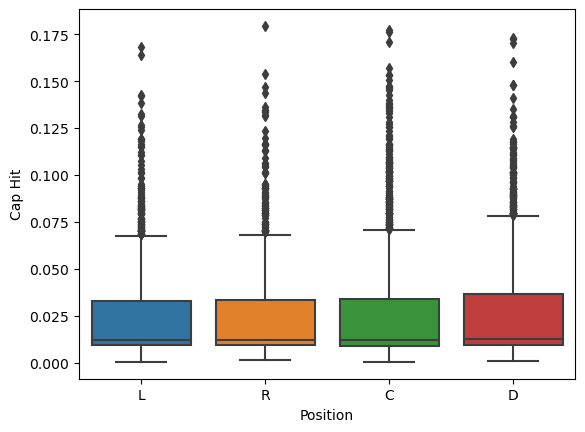

In [13]:
# boxplot of cap hit vs position
sns.boxplot(data=data,x='Position',y='Cap Hit');

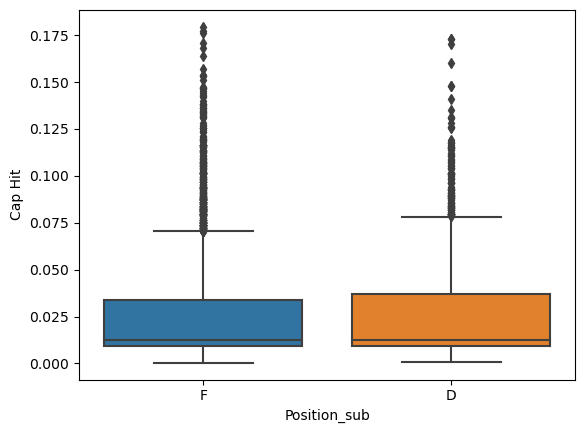

In [14]:
# boxplot of cap hit vs position category
sns.boxplot(data=data,x='Position_sub',y='Cap Hit');

From the boxplots above, we can see that there is a slight distinction, though small, between forwards and defensemen, where it appears that the average cap hit of defense contracts are slightly higher than those of forwards.

In [15]:
# look at number of players of each nationality
data['Nationality'].value_counts(normalize=True)

CAN    0.522140
USA    0.267800
SWE    0.063053
CZE    0.039320
FIN    0.030287
RUS    0.025859
SVK    0.012221
CHE    0.009210
DEU    0.006730
DNK    0.005313
LVA    0.003542
FRA    0.002480
AUT    0.002303
BLR    0.002303
NOR    0.001948
UKR    0.001771
LTU    0.001063
POL    0.000531
NLD    0.000531
AUS    0.000531
GBR    0.000354
SVN    0.000354
NGA    0.000177
HRV    0.000177
Name: Nationality, dtype: float64

From the breakdown of contracts by nationality, we can see that most (nearly 70%) are attributed to Canadian and American players.

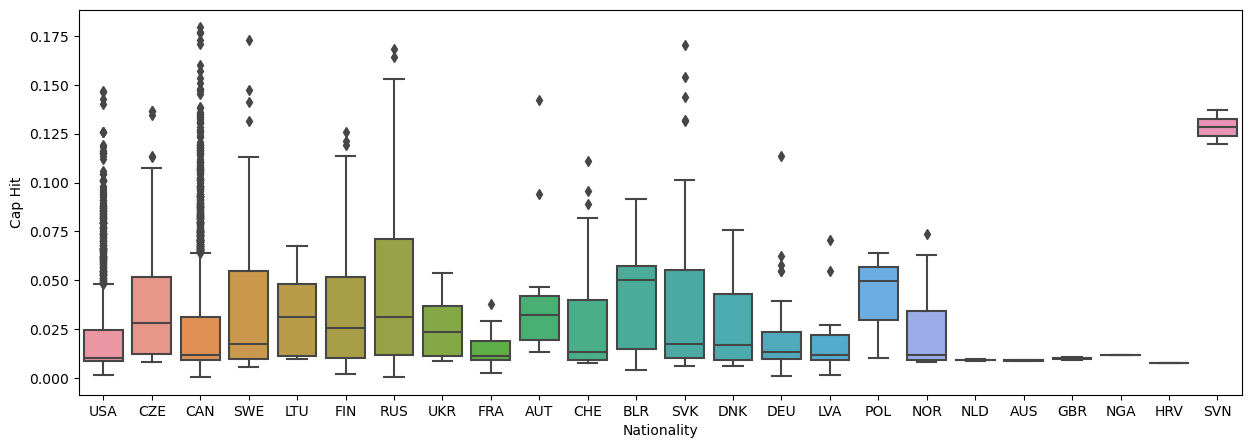

In [16]:
# boxplot of cap hit vs player nationality
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.boxplot(data=data,x='Nationality',y='Cap Hit',ax=ax);

Now looking at salary cap hit by player nationality, there is a lot more divergence, though we can draw a couple of interesting conclusions:
1. The USA and Canada, while have among the lowest median cap hits, also have by far the most outliers - this is likely a consequence of having by far the most players from these countries, and thus encompassing the largest range of salaries
2. Slovenia offered the highest median cap hit of all the countries included, though a very small number of contracts attributed, suggesting the limited number of contracts there were higher

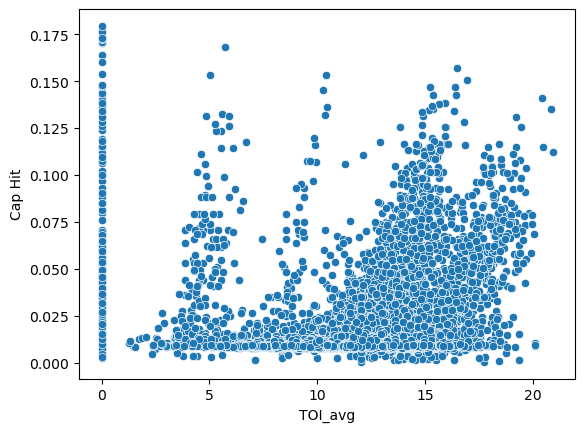

In [17]:
# look at salary cap vs draft pick
sns.scatterplot(x=data['TOI_avg'],y=data['Cap Hit']);

From this chart, we get an interesting finding - that there is a substantial number of observations where average time-on-ice is zero. Before proceeding, we should look at the distribution of this variable, and possibly look to exclude those observations, even if they are technically not missing.

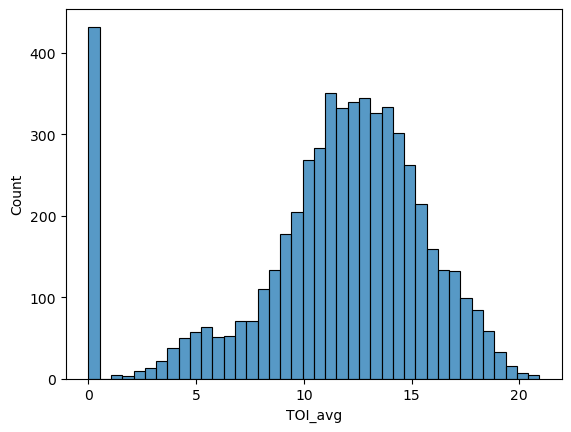

In [18]:
# histogram of average TOI
sns.histplot(data['TOI_avg']);

Here we see that while the TOI is a somewhat normally distributed variable, there are a substantial number of observations where the associated average TOI is zero - given the construction of the features, that means the TOI for the three years proceeding the contract must also be zero. The next step is to conclude whether or not these observations can be trusted.

In [19]:
# find observations where TOI is zero and games played is zero
data[(data['TOI_avg'] == 0) & (data['GAMES_PLAYED_avg'] == 0)]

Length  Contract Age   Cap Hit Position Nationality  Height  \
2471     2.0          30.0  0.008896        D         USA    75.0   
3238     1.0          29.0  0.008589        R         CAN    72.0   
4473     2.0          25.0  0.008896        C         USA    73.0   
5051     1.0          23.0  0.012326        C         CAN    70.0   

      Overall Pick  GAMES_PLAYED_t  G_t  A_t  ...  xG±/60_PLAYOFF_avg  \
2471          35.0             0.0  0.0  0.0  ...                0.55   
3238         121.0             0.0  0.0  0.0  ...               -0.09   
4473         174.0             0.0  0.0  0.0  ...               -0.56   
5051          17.0             0.0  0.0  0.0  ...                0.14   

      RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  \
2471                   0.79             -34.79                -33.58   
3238                   0.09              22.32                 16.94   
4473                   0.04              -4.94                 -3.33   
5051                   0.80              20.23                 41.08   

      G_PG_avg  P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  \
2471       0.0       0.0         0.0               0.0          1.000000   
3238       0.0       0.0         0.0               0.0          0.166667   
4473       0.0       0.0         0.0               0.0          0.000000   
5051       0.0       0.0         0.0               0.0          0.333333   

      Position_sub  
2471             D  
3238             F  
4473             F  
5051             F  

[4 rows x 124 columns]

We find four observations where average TOI is zero and the number of games played is also zero - these are sensible observations because if a player is not playing in any games, then there TOI will as a result be equal to zero. We should keep these observations.

In [20]:
# find observations where TOI is zero and games played is not zero
bad_rows = (list(data[(data['TOI_avg'] == 0) & (data['GAMES_PLAYED_avg'] != 0)].index) + 
            list(data[(data['TOI_PLAYOFF_avg'] == 0) & (data['GP_PLAYOFF_avg'] != 0)].index))

In [21]:
# get unique observations
bad_rows = list(set(bad_rows))

In [22]:
len(bad_rows)

483

Since it is pretty nonsensical that a player could play in a nonzero number of games over the course of three years and still be considered to have zero ice time, we need to treat these observations as effectively 'missing' and drop them from the dataset.

In [23]:
# drop effectively missing data from table
data = data.drop(bad_rows,axis=0)

In [24]:
data.shape

(5163, 124)

With those observations removed, we can re-confirm the distribution of the TOI variable, and also assess how it impacts cap hit.

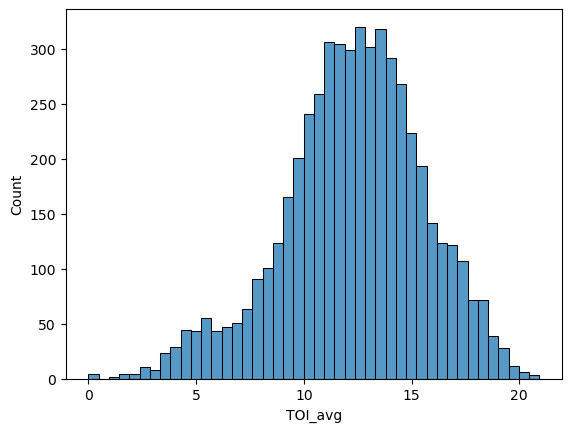

In [25]:
# histogram of average TOI
sns.histplot(data['TOI_avg']);

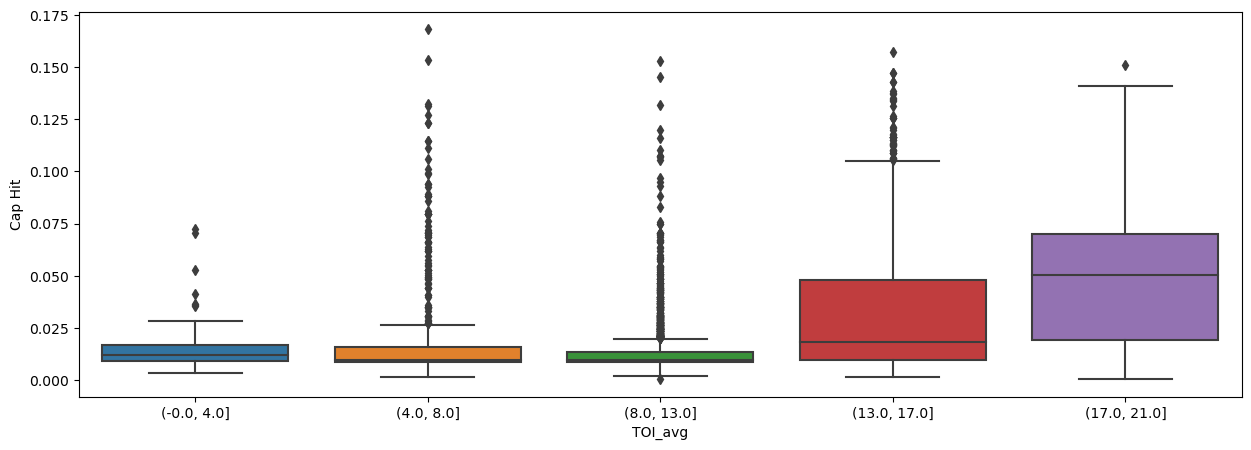

In [26]:
# plot TOI vs cap hit
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_toi = pd.cut(data['TOI_avg'],bins=5,precision=0)
sns.boxplot(x=cut_toi,y=data['Cap Hit']);

We see here a pattern similar to that of the number of games played, though the trend is less clear. That said, it is obvious here that more TOI on ice is associated with a higher cap hit, which again might be more of an effect than a cause; it is probable that teams will want more highly-paid players to have more time on ice, presumably on account of skill but also perhaps because of some bias that the higher cap-hit players have more resources invested in them, and as a result should have to play more.

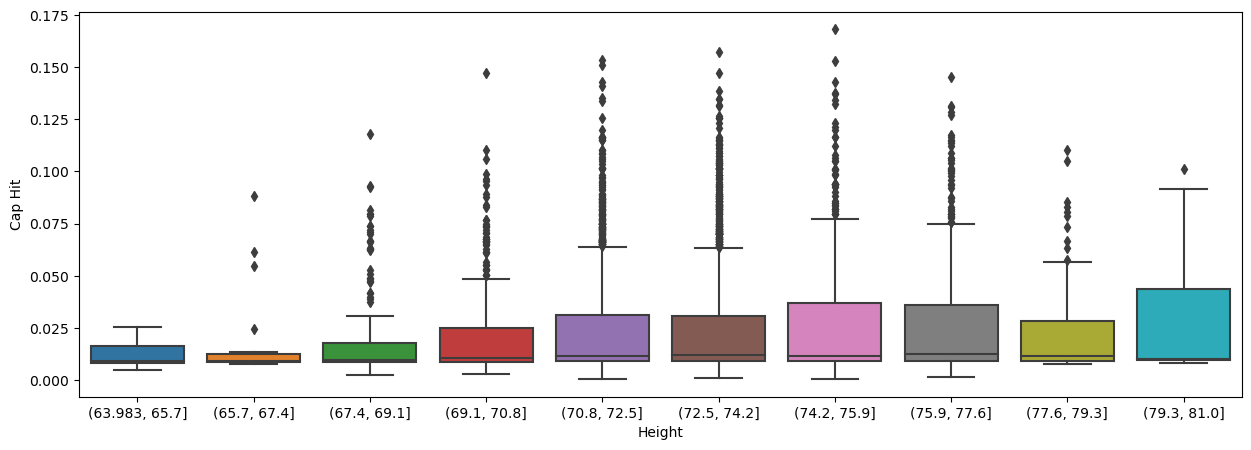

In [27]:
# look at salary cap vs height
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_height = pd.cut(data['Height'],bins=10)
sns.boxplot(x=cut_height,y=data['Cap Hit']);

While there is not an obvious relationship between salary cap hit and height, it does appear that shorter players tended to have lower cap hits, whereas taller players, who still had a range of cap hits, had more potential for higher salaries than their shorter counterparts. Overall, however, height does not appear to be a strong driver of salary.

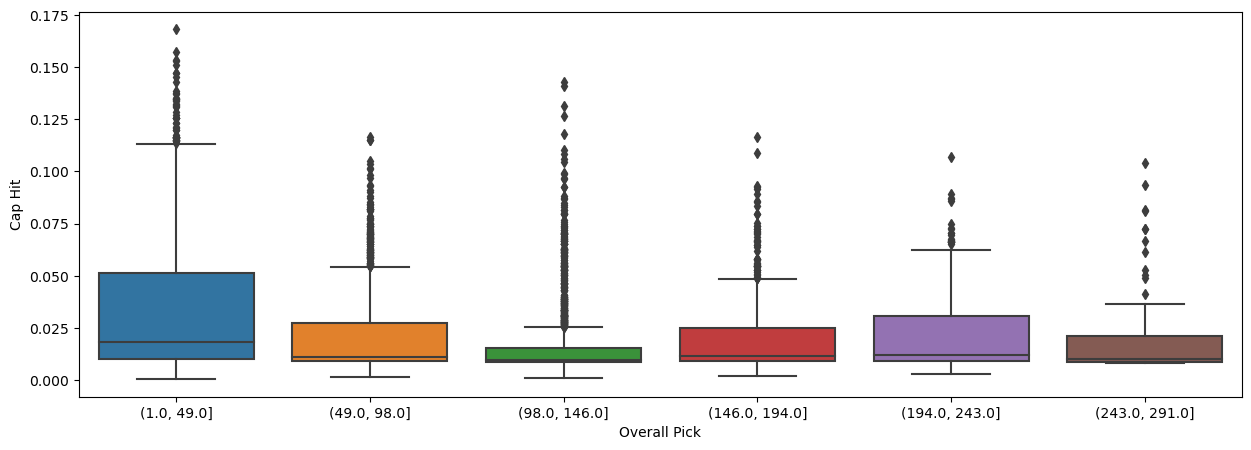

In [28]:
# look at salary cap vs draft pick
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_draftPick = pd.cut(data['Overall Pick'],bins=6,precision=0)
sns.boxplot(x=cut_draftPick,y=data['Cap Hit']);

Overall pick in the NHL draft is considered historically to be a strong indicator because the success of early draft picks tends to draw much publicity. While the above splot shows that the median contract is indeed higher for the first 49 picks in the draft, the median cap hits for players taken outside that appear to be similar.

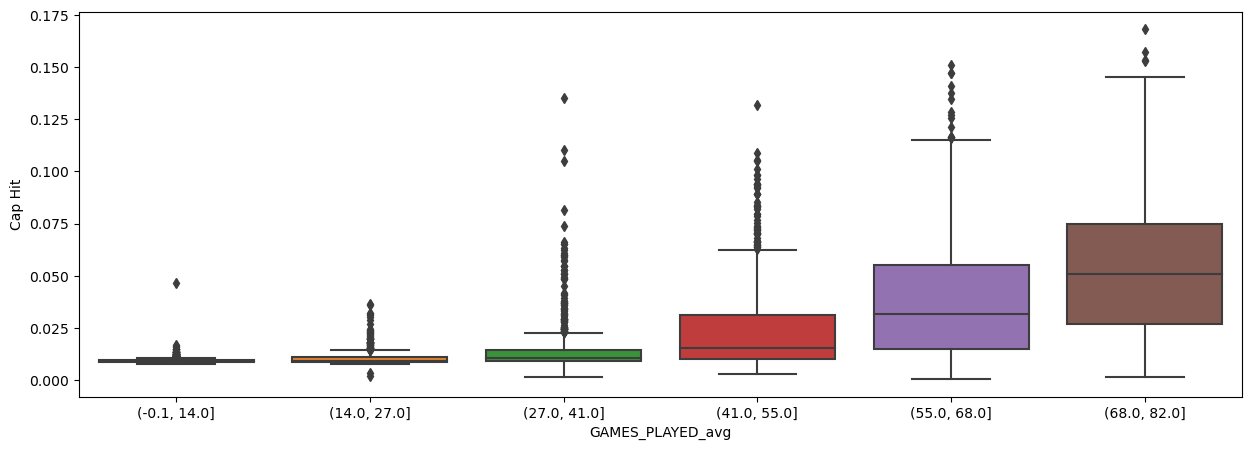

In [29]:
# look at salary cap vs draft pick
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_gamesPlayed = pd.cut(data['GAMES_PLAYED_avg'],bins=6,precision=0)
sns.boxplot(x=cut_gamesPlayed,y=data['Cap Hit']);

Unsurprisingly, salary cap hit does increase quite a lot with games played; strong players are likely to be played in as many games as possible, rather than be healthy scratches, for example, and moreover, number of games played is a typical indicator of health (i.e. no injuries), which is also a positive signal in contract negotiations, because injured players present a risk to the value of a future contract.

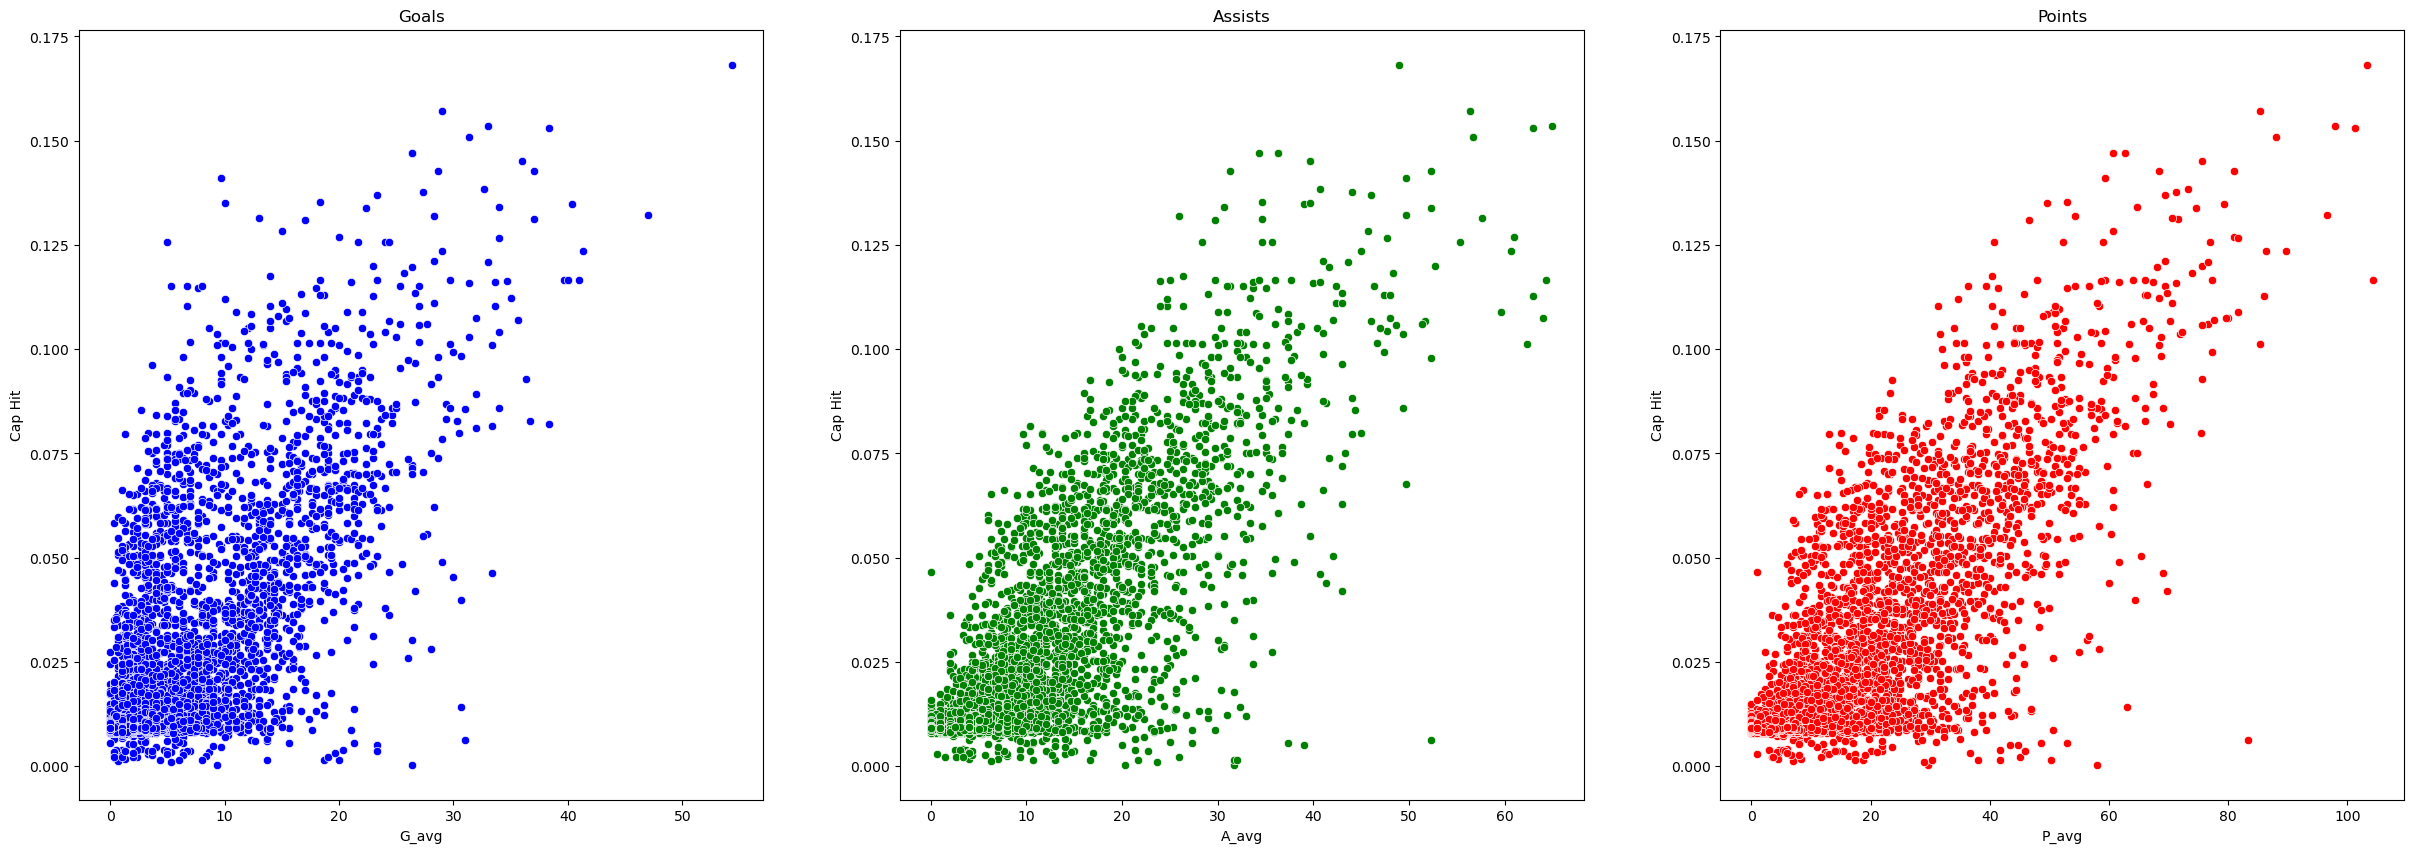

In [30]:
# look at salary cap vs draft pick
fig,ax = plt.subplots(1,3,figsize=(30,10))
sns.scatterplot(x=data['G_avg'],y=data['Cap Hit'],ax=ax[0],c='b')
ax[0].set_title('Goals')
sns.scatterplot(x=data['A_avg'],y=data['Cap Hit'],ax=ax[1],c='g')
ax[1].set_title('Assists')
sns.scatterplot(x=data['P_avg'],y=data['Cap Hit'],ax=ax[2],c='r')
ax[2].set_title('Points');

In one of the cleanest visuals yet, we can see that salary cap increases with goals, assists, and points (the sum of goals and assists). The relationship is slightly stronger in assists and points, most likely because assists typically make up a larger portion of a players point total, as multiple players can have an assist on a goal. 

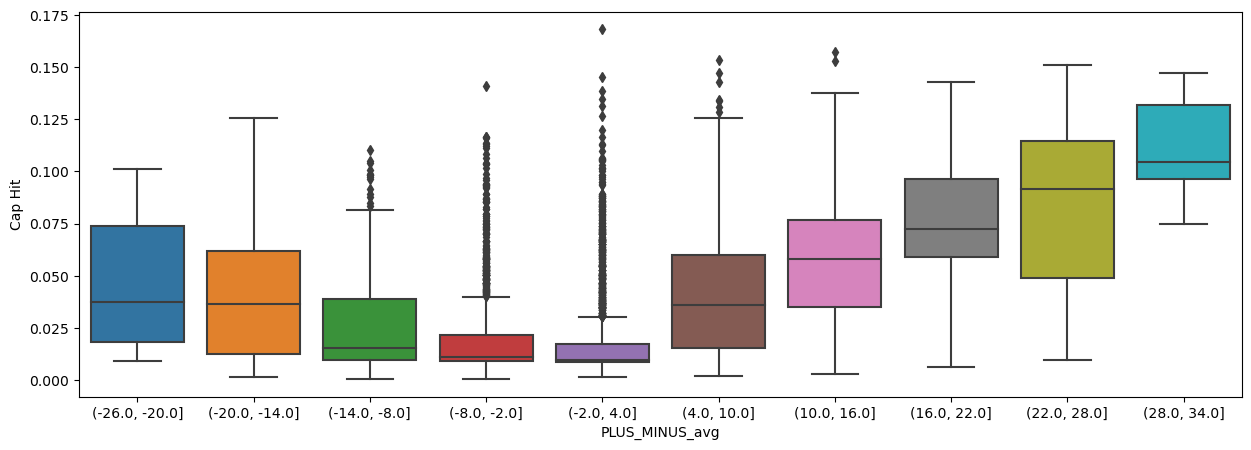

In [31]:
# look at salary cap vs draft pick
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_plusMinus = pd.cut(data['PLUS_MINUS_avg'],bins=10,precision=0)
sns.boxplot(x=cut_plusMinus,y=data['Cap Hit']);

Interestingly, there appears to be an unusually-shaped relationship between plus-minus and salary cap hit. Though cap hit increases with plus-minus score from zero, it appears that it increases with worse scores as well. The best explanation for this is that highly paid players on poorly performing teams will have poor plus-minus scores on account of his team being ultimately outscored, so plus-minus score, as a drawback to the metric, does encapsulate some of the team performance that might obscure the reality of a player's value to the team.

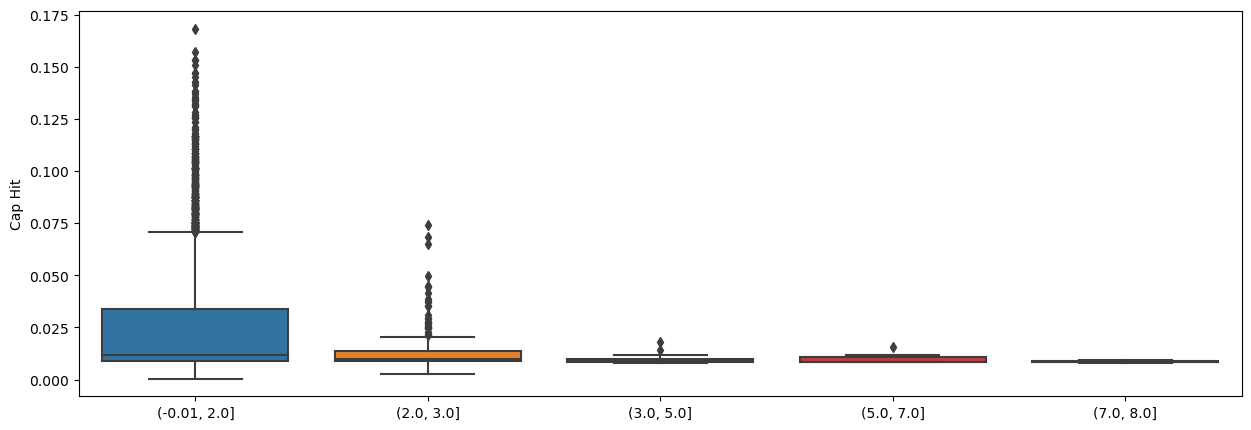

In [32]:
# plot PIM vs cap hit
fig,ax = plt.subplots(1,1,figsize=(15,5))
cut_pim = pd.cut(data['PIM_avg']/data['GAMES_PLAYED_avg'],bins=5,precision=0)
sns.boxplot(x=cut_pim,y=data['Cap Hit']);

In what is also an unsurprising finding, players with less penalty minutes per game tend to be more highly compensated, though it does not appear to have too strong an effect on the median cap hit, more so being the case that the most highly compensated players appear to have low penalty minute counts. This makes sense because, despite spending more time on ice, better players are likely to avoid taking penalities via skilled play, and more so will have less desire to expose their teams to man disadvantages that occur with penalty minutes. 

Since most of the other advanced statistics are continuous and expected to be somewhat correlated to player performance, we will examine those via a pairs plot.

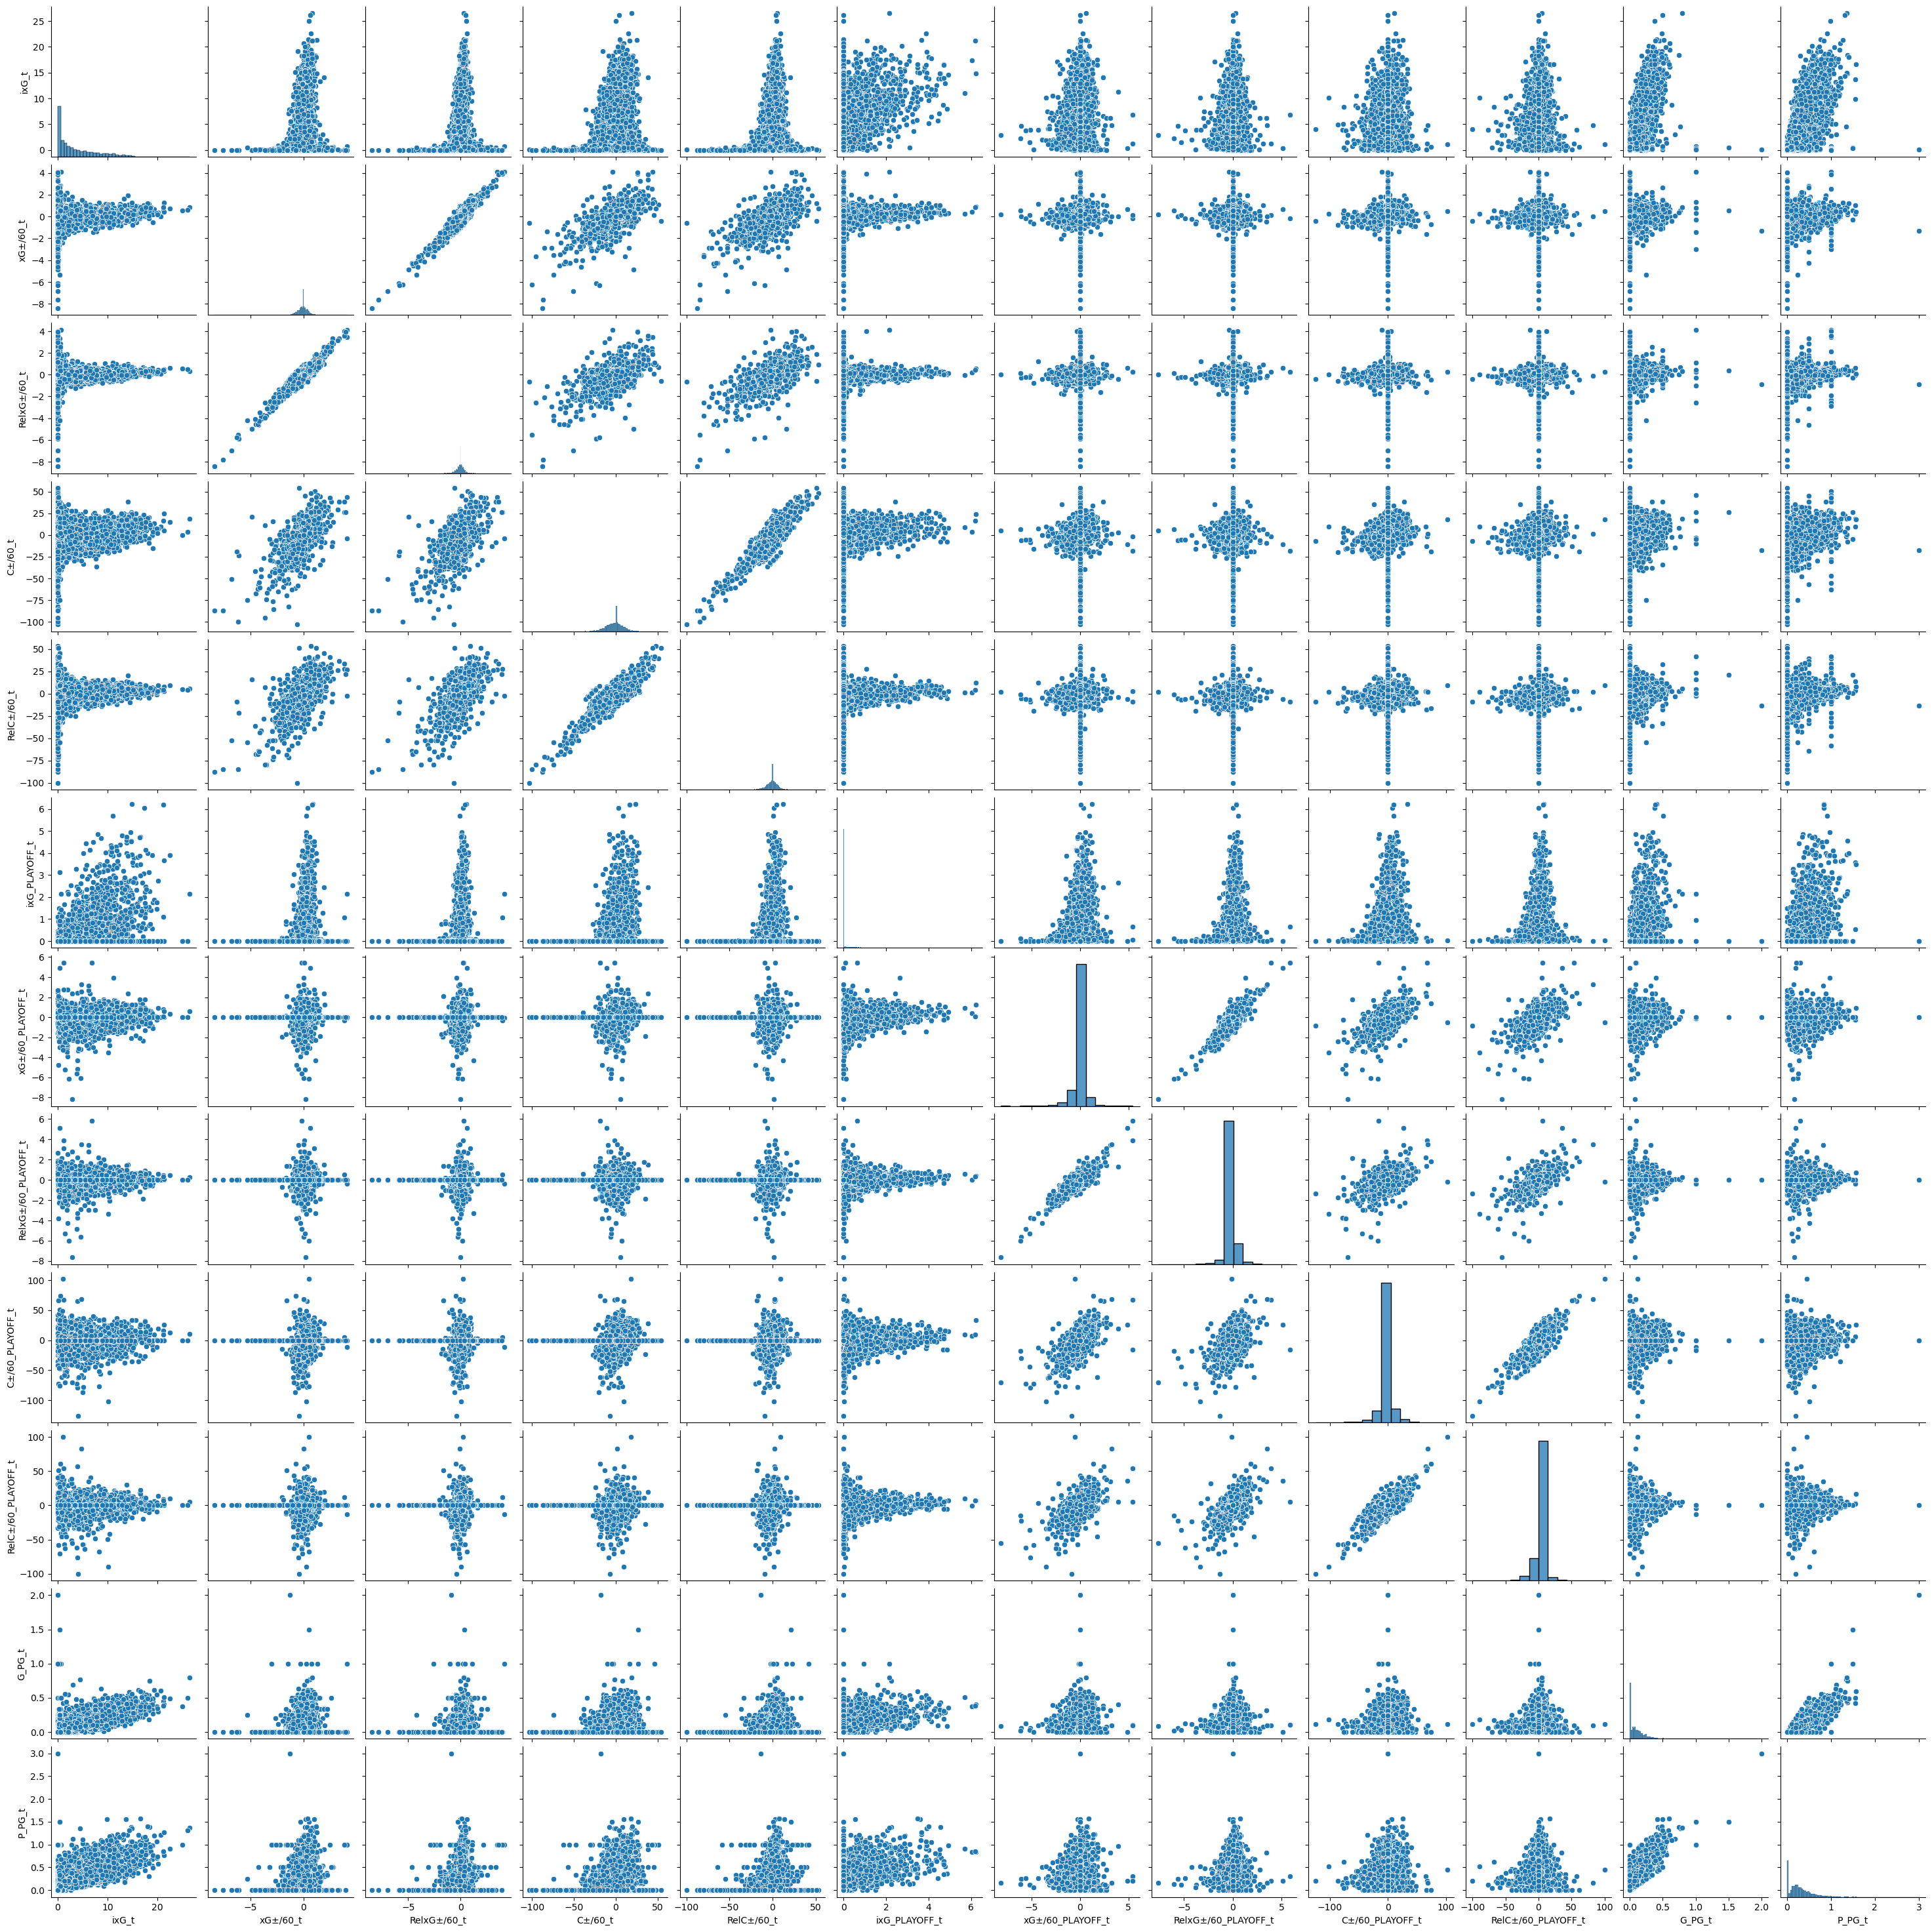

In [33]:
data_sub_pairs = data[['ixG_t', 'xG±/60_t', 'RelxG±/60_t', 'C±/60_t', 'RelC±/60_t', 'ixG_PLAYOFF_t',
                      'xG±/60_PLAYOFF_t', 'RelxG±/60_PLAYOFF_t', 'C±/60_PLAYOFF_t', 'RelC±/60_PLAYOFF_t',
                      'G_PG_t', 'P_PG_t']]
sns.pairplot(data_sub_pairs);

# Modelling

The modelling process for this project is twofold; because we are trying to predict the value of a player's contract, we need to separately model the annual cap hit of the contract, as well as the length of the contract. The annual dollar value (AAV) of the contract multiplied by the length of the contract gives the total contract value. 

First, the data needs to be further prepared for modeling. This involves splitting the data into training and test sets, encoding the categorical variables, and scaling the numeric variables. 

Second, for the model approaches used, cross-validation will be performed on the training set. We will use grid search with cross-validation to obtain the best parameters for each model tested.

Finally, a final model with the selected parameterization will be fitted on the full training set, and then run on the test set. The final model with the lowest mean average error on the test set will be selected as the final model and used for prediction on the new data. 

The choice of scoring metric is an important one in model selection, because choosing a model based on one metric or another might ultimately lead to a different set of predictions with new data. For regression-based error metrics, two typical choices are mean average error and root mean squared error. I have chosen mean average error as the preferred metric for two reasons:

1. the error term becomes directly interpretable; we are able to say that any predicted contract is on average off by some amount of yearly value and length, which gives the stakeholders a direct intuition for the usefulness of the model.
2. without a bias towards a certain kind of error distribution - for example, we cannot say with certainty that being off by a lot on a single contract is worse than being off by a lesser amount on multiple - the mean average error becomes the more conservative choice of metric.

### Data Preparation

First, we need to split the data into dependent and independent variables. In this case, the independent variables are the same for both models, and there are two different vectors for the dependent variables.

In [53]:
# create a copy of data
data = data.drop(columns=['Position_sub'],axis=1)

KeyError: "['Position_sub'] not found in axis"

In [54]:
# split data for cap hit model
y = data['Cap Hit']
y_l = data['Length']
X = data.drop(columns=['Cap Hit','Length'],axis=1)

Now that the data is split into independent and dependent variables for each model, we can split them into training and test sets.

In [55]:
# split data into train-test sets
X_train,X_test,y_train,y_test,y_l_train,y_l_test = train_test_split(X,y,y_l,test_size=0.25,random_state=100)

Finally, we can encode the categorical features, and scale the numeric features.

In [56]:
# split data into categorical variables
categorical_variables = ['Position','Nationality']
X_train_categorical = X_train[categorical_variables]
X_train_numeric = X_train.drop(columns=categorical_variables,axis=1)

# encode categorical variables
ohe_X_train = OneHotEncoder(sparse=False)
x_train_categorical = ohe_X_train.fit_transform(X_train_categorical)
X_train_categorical = pd.DataFrame(x_train_categorical,columns=ohe_X_train.get_feature_names_out())

# scale numeric variables
scaler_X_train = StandardScaler()
x_train_numeric = scaler_X_train.fit_transform(X_train_numeric)
X_train_numeric = pd.DataFrame(x_train_numeric,columns=X_train_numeric.columns)

# re-combine categorical and numeric features
X_train = pd.concat([X_train_categorical,X_train_numeric],axis=1)

In [57]:
X_train.head()

Position_C  Position_D  Position_L  Position_R  Nationality_AUS  \
0         0.0         1.0         0.0         0.0              0.0   
1         0.0         0.0         0.0         1.0              0.0   
2         1.0         0.0         0.0         0.0              0.0   
3         1.0         0.0         0.0         0.0              0.0   
4         0.0         0.0         0.0         1.0              0.0   

   Nationality_AUT  Nationality_BLR  Nationality_CAN  Nationality_CHE  \
0              0.0              0.0              0.0              0.0   
1              0.0              0.0              1.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              1.0              0.0   
4              0.0              0.0              0.0              0.0   

   Nationality_CZE  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0              0.0  ...        -0.527658           -0.908364   
1              0.0  ...        -0.527658            0.127259   
2              0.0  ...         0.191770            0.040957   
3              0.0  ...        -0.527658            0.127259   
4              0.0  ...        -0.527658            0.127259   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0              -0.115481           2.321805              4.343117 -0.574231   
1               0.058178           0.120042              0.052526 -0.967332   
2               0.130536           0.267434              0.528362  0.388867   
3               0.058178           0.120042              0.052526 -0.684791   
4               0.058178           0.120042              0.052526 -0.546805   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0 -0.998249   -0.880080          -0.48261         -0.575089  
1 -0.970563   -0.880080          -0.48261         -0.575089  
2 -0.093548   -0.029384          -0.48261         -0.078393  
3 -1.010361    0.556403          -0.48261         -0.575089  
4 -0.770645   -0.668628          -0.48261         -0.575089  

[5 rows x 147 columns]

In [39]:
X_train.shape

(3872, 147)

In [40]:
# apply same transformations to test set
X_test_categorical = X_test[categorical_variables]
X_test_numeric = X_test.drop(columns=categorical_variables,axis=1)

x_test_categorical = ohe_X_train.transform(X_test_categorical)
X_test_categorical = pd.DataFrame(x_test_categorical,columns=ohe_X_train.get_feature_names_out())

x_test_numeric = scaler_X_train.transform(X_test_numeric)
X_test_numeric = pd.DataFrame(x_test_numeric,columns=X_test_numeric.columns)

X_test = pd.concat([X_test_categorical,X_test_numeric],axis=1)

In [41]:
X_test.head()

Position_C  Position_D  Position_L  Position_R  Nationality_AUS  \
0         0.0         1.0         0.0         0.0              0.0   
1         1.0         0.0         0.0         0.0              0.0   
2         0.0         0.0         1.0         0.0              0.0   
3         1.0         0.0         0.0         0.0              0.0   
4         0.0         0.0         0.0         1.0              0.0   

   Nationality_AUT  Nationality_BLR  Nationality_CAN  Nationality_CHE  \
0              0.0              0.0              1.0              0.0   
1              0.0              0.0              0.0              0.0   
2              0.0              0.0              0.0              0.0   
3              0.0              0.0              0.0              0.0   
4              0.0              0.0              1.0              0.0   

   Nationality_CZE  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0              0.0  ...        -0.527658            0.127259   
1              0.0  ...        -0.496826            0.854661   
2              0.0  ...        -0.527658            0.127259   
3              0.0  ...         0.335655            0.036848   
4              0.0  ...        -0.198777            1.384802   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0               0.058178           0.120042              0.052526  0.026949   
1               0.376553           1.502022              1.417306 -0.112585   
2               0.058178           0.120042              0.052526 -0.402249   
3               0.781757           0.492500              0.923548 -0.038078   
4               0.087121           0.553797             -0.409272  1.053708   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0  0.684869   -0.075713         -0.482610         -0.575089  
1 -0.453962   -0.739470         -0.482610         -0.575089  
2 -0.676054   -0.501228         -0.482610         -0.575089  
3  0.108612   -0.325472         -0.482610         -0.291263  
4  0.561381    0.038180          2.078527          1.080564  

[5 rows x 147 columns]

In [42]:
X_test.shape

(1291, 147)

### Cap Hit Modelling

Now that the data is prepared, we will start by iteratively building models. For each model, we will use GridSearchCV on the training data. Then, we will build a final model using the parameters for the performing model, and train that model on the training data. This same model can be run on the test data to get an out-of-sample score that can help us determine the final model to use for prediction.

In [113]:
# initialize dataframe to store model errors
cap_hit_error = pd.DataFrame()

#### Ridge Regression

In [120]:
# initialize ridge regression and parameters
ridge = linear_model.Ridge(random_state=100)
ridge_parameters = {'alpha': np.concatenate((np.arange(0.1,2,0.1),np.arange(2, 5, 0.5),np.arange(5, 25, 1))),
                    'positive': [True,False],
                    'fit_intercept': [True,False]}

In [121]:
# perform grid search
gs_ridge = GridSearchCV(ridge,ridge_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_ridge.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=100),
             param_grid={'alpha': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.5,  3. ,
        3.5,  4. ,  4.5,  5. ,  6. ,  7. ,  8. ,  9. , 10. , 11. , 12. ,
       13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. , 22. , 23. ,
       24. ]),
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_absolute_error', verbose=False)

In [122]:
gs_ridge.best_params_

{'alpha': 24.0, 'fit_intercept': True, 'positive': False}

In [123]:
gs_ridge.best_score_

-0.008435256234907092

In [125]:
# build final model using best params
ridge_final = linear_model.Ridge(alpha=9,fit_intercept=True,positive=False,random_state=100)
ridge_final.fit(X_train,y_train)

Ridge(alpha=9, random_state=100)

In [134]:
# get final model error
ridge_predict = ridge_final.predict(X_test)
ridge_final_mae = mean_absolute_error(ridge_final.predict(X_test),y_test)
ridge_final_mae

0.008158950826078558

In [129]:
# add ridge mae to dataframe
cap_hit_error.loc['Ridge Regression','Contract Annual Value'] = ridge_final_mae
cap_hit_error

MAE
Ridge Regression  0.008159

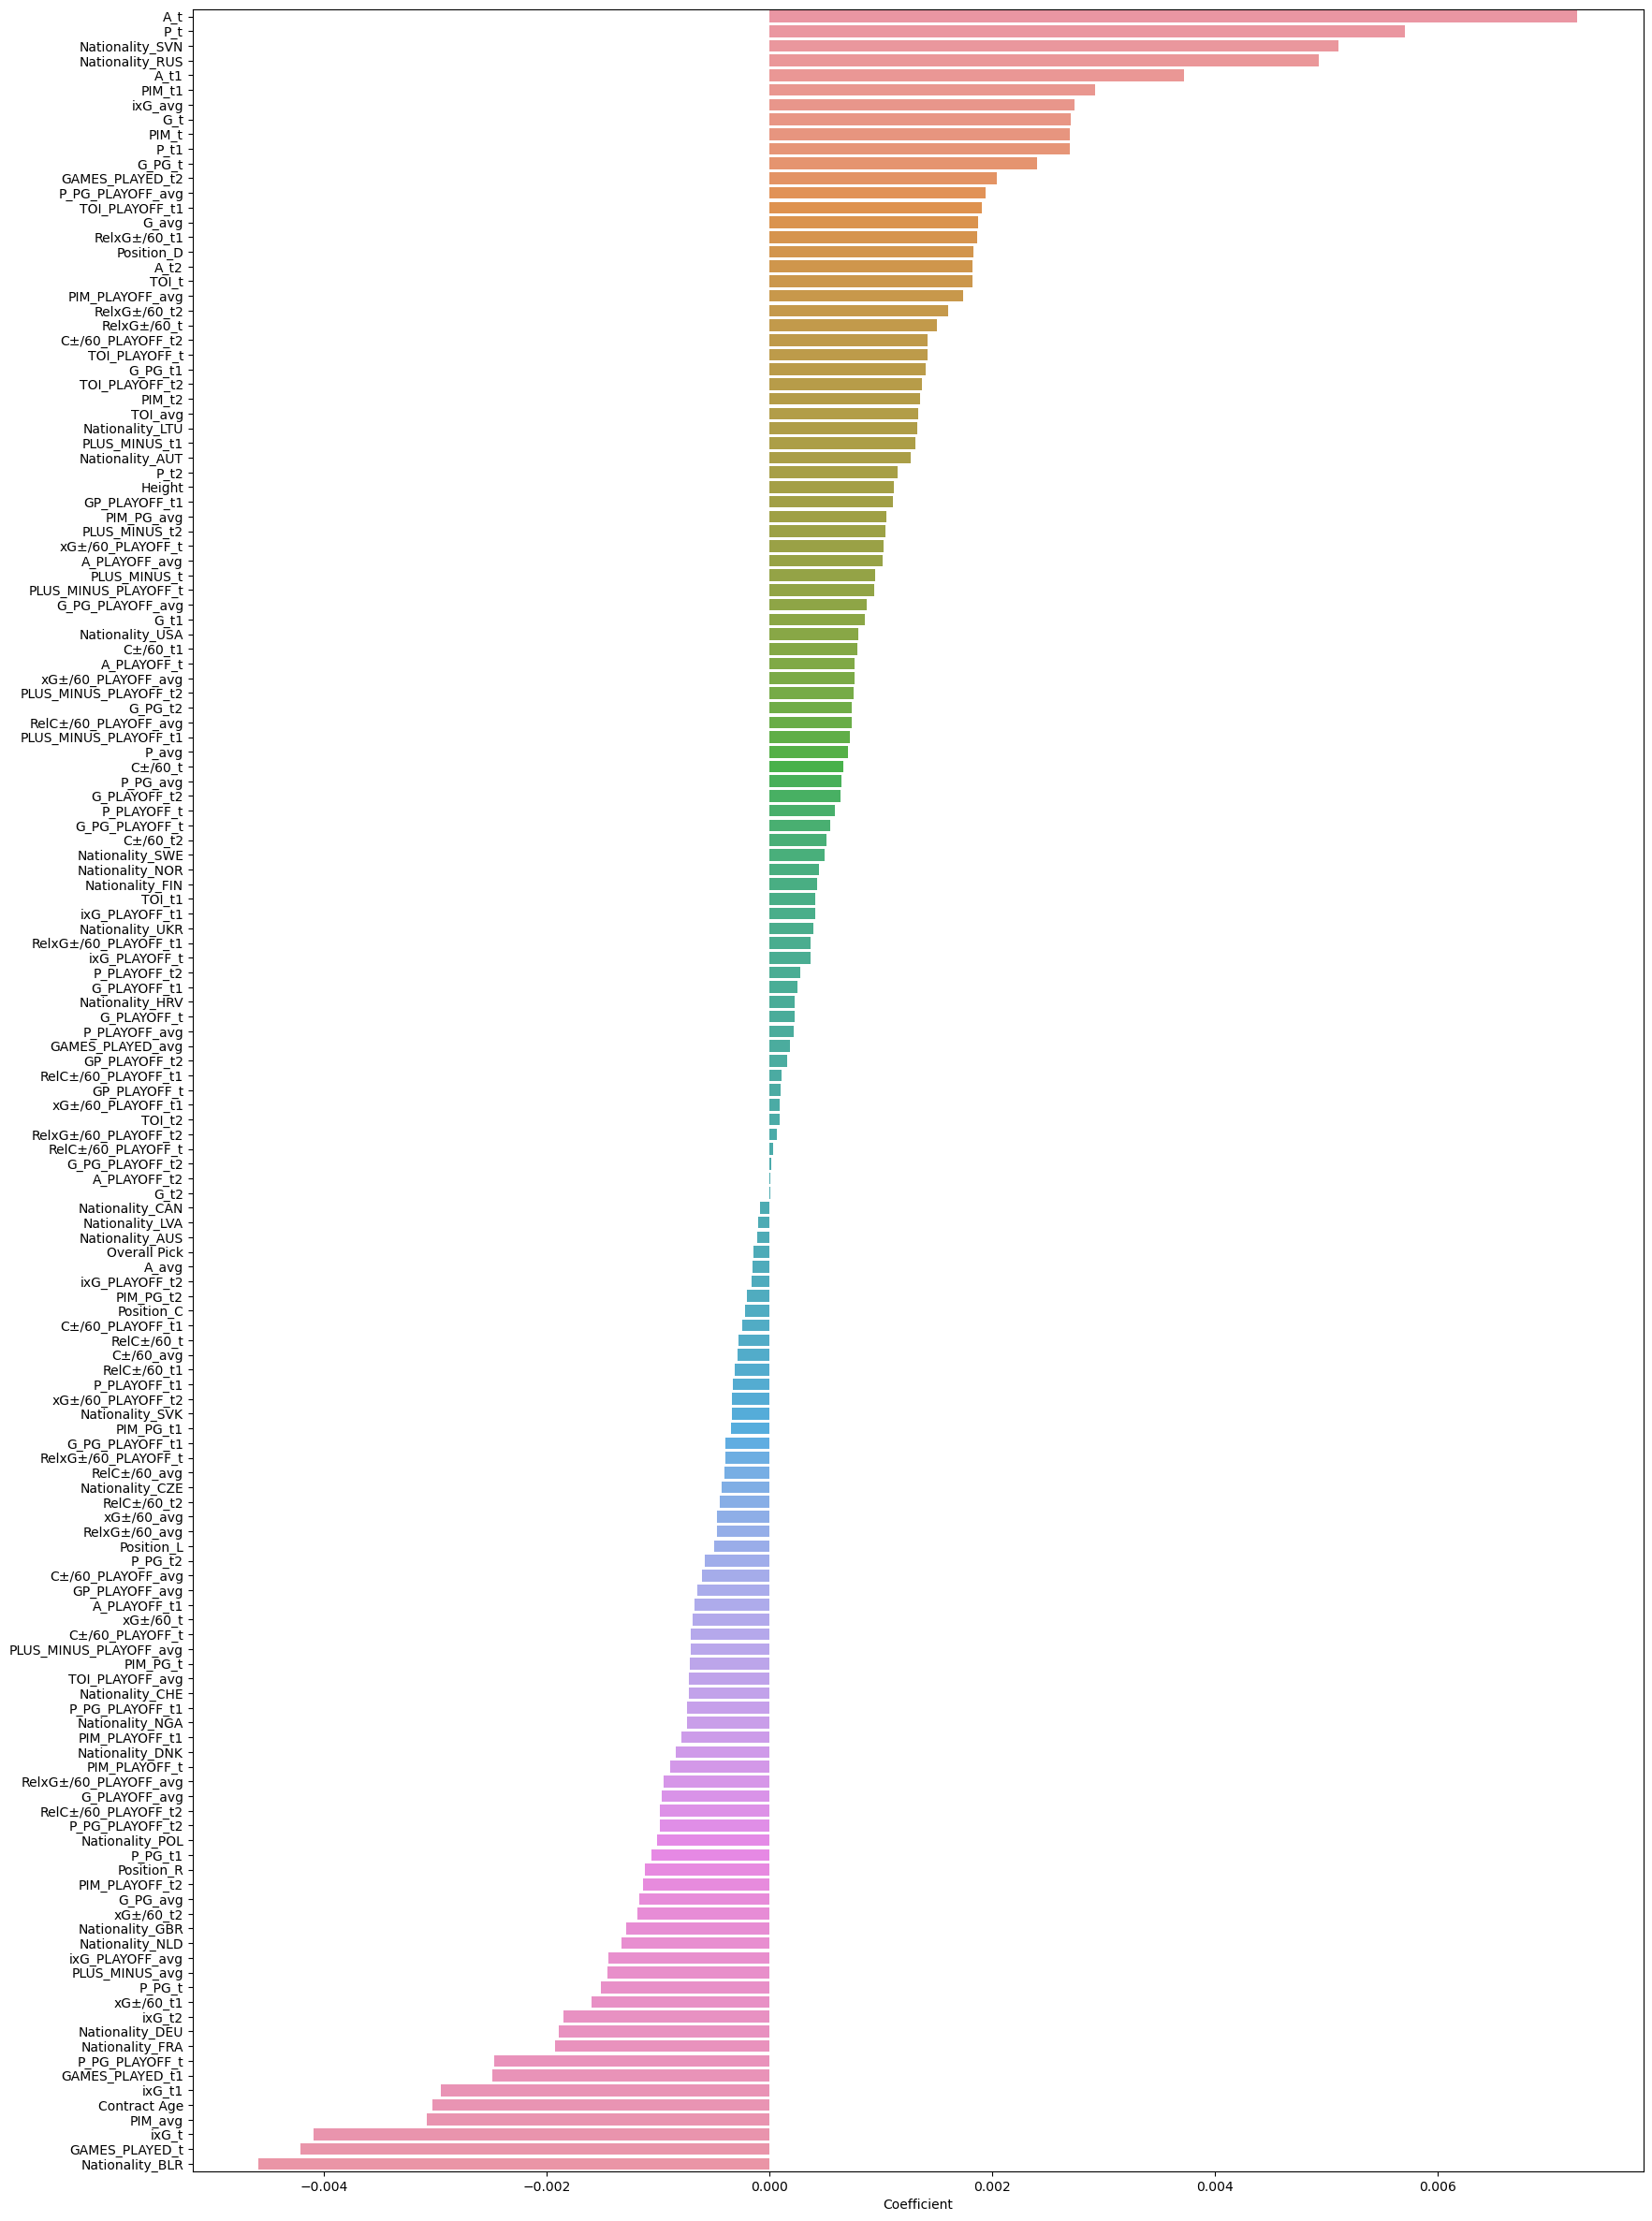

In [177]:
# get coefficients chart
ridge_coef = pd.DataFrame(pd.Series(ridge_final.coef_,index=ridge_final.feature_names_in_)).sort_values(by=0,ascending=False)
ridge_coef.columns = ['Coefficient']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=ridge_coef.index,x=ridge_coef['Coefficient']);

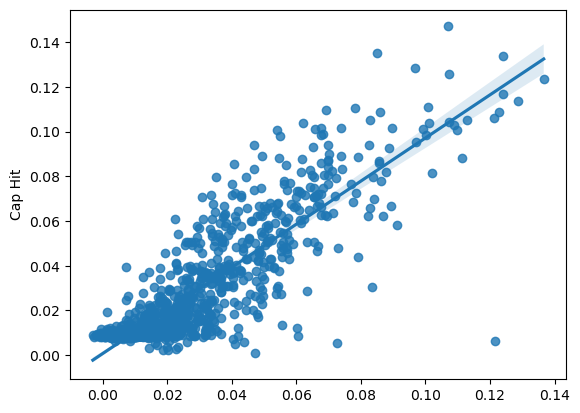

In [135]:
# plot true values vs residuals
sns.regplot(x=ridge_predict,y=y_test);

The final ridge regression model has an out-of-sample MAE of 0.008159. While ridge regression is typically poor for feature selection, among the largest coefficients are assists and points by a player in a contract year, which are features that we would expect to be significant in predicting cap hits.

#### LASSO

In [140]:
# initialize LASSO
lasso = linear_model.Lasso(random_state=100)
lasso_parameters = {'alpha': np.concatenate((np.arange(0.005,2,0.005),np.arange(2,5,0.5),np.arange(5,25,1))),
                    'positive': [True,False],
                    'fit_intercept': [True,False]}

In [141]:
# perform grid search
gs_lasso = GridSearchCV(lasso,lasso_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_lasso.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(random_state=100),
             param_grid={'alpha': array([5.000e-03, 1.000e-02, 1.500e-02, 2.000e-02, 2.500e-02, 3.000e-02,
       3.500e-02, 4.000e-02, 4.500e-02, 5.000e-02, 5.500e-02, 6.000e-02,
       6.500e-02, 7.000e-02, 7.500e-02, 8.000e-02, 8.500e-02, 9.000e-02,
       9.500e-02, 1.000e-01, 1.050e-01, 1.100e-01, 1.150e-01, 1.200e-01,
       1.250e-01, 1.300e-01, 1.350e-01, 1...
       1.985e+00, 1.990e+00, 1.995e+00, 2.000e+00, 2.500e+00, 3.000e+00,
       3.500e+00, 4.000e+00, 4.500e+00, 5.000e+00, 6.000e+00, 7.000e+00,
       8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01,
       1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01, 1.800e+01, 1.900e+01,
       2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01, 2.400e+01]),
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_absolute_error', verbose=False)

In [142]:
gs_lasso.best_params_

{'alpha': 0.005, 'fit_intercept': True, 'positive': False}

In [144]:
gs_lasso.best_score_

-0.009750810000090069

In [145]:
# build final model using best params
lasso_final = linear_model.Lasso(alpha=0.005,fit_intercept=True,positive=False,random_state=100)
lasso_final.fit(X_train,y_train)

Lasso(alpha=0.005, random_state=100)

In [146]:
# get final model error
lasso_predict = lasso_final.predict(X_test)
lasso_final_mae = mean_absolute_error(lasso_final.predict(X_test),y_test)
lasso_final_mae

0.009367826364489584

In [147]:
# add lasso mae to dataframe
cap_hit_error.loc['LASSO Regression','Contract Annual Value'] = lasso_final_mae
cap_hit_error

MAE
Ridge Regression  0.008159
LASSO Regression  0.009368

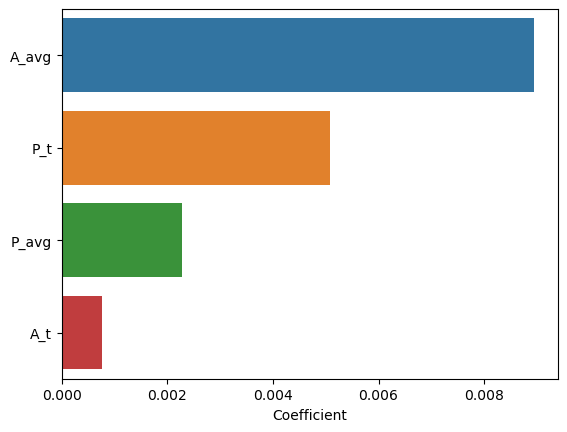

In [161]:
# get coefficients chart
lasso_coef = pd.DataFrame(pd.Series(lasso_final.coef_,index=lasso_final.feature_names_in_)).sort_values(by=0,ascending=False)
lasso_coef.columns = ['Coefficient']
lasso_coef = lasso_coef[lasso_coef['Coefficient'] != 0]
sns.barplot(y=lasso_coef.index,x=lasso_coef['Coefficient']);

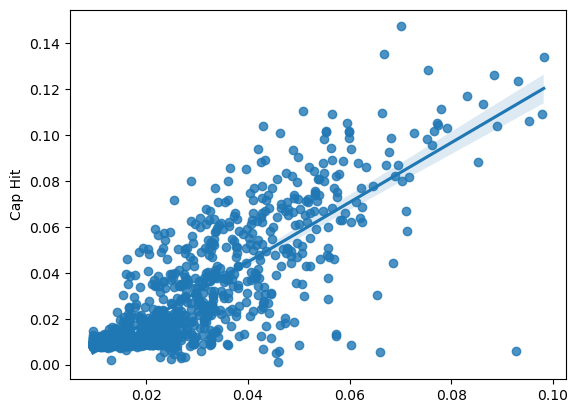

In [163]:
# plot true values vs residuals
sns.regplot(x=lasso_predict,y=y_test);

The LASSO model has a worse out-of-sample performance than the ridge regression model, however it is more helpful in determining feature importance given that is provides actual feature selection. The features that the LASSO model has selected are average points and assists, and points and assists in the contract year. This is expected on the basis of intution and the results of the ridge regression model, but it is notable that the LASSO model performs only slightly worse in absolute terms with just four features, signaling the importance of these featurse in predict salary cap hits.

#### Elastic Net

In [293]:
# initialize Elastic Net
eln = linear_model.ElasticNet(random_state=100)
eln_parameters = {'alpha': np.arange(0,1,0.005),
                  'fit_intercept': [True,False]}

In [294]:
# perform grid search
gs_eln = GridSearchCV(eln,eln_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_eln.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=100),
             param_grid={'alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0...
       0.72 , 0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 ,
       0.765, 0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805,
       0.81 , 0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 ,
       0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895,
       0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 ,
       0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985,
       0.99 , 0.995]),
                         'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error', verbose=False)

In [295]:
gs_eln.best_score_

-0.008508797412482179

In [296]:
gs_eln.best_params_

{'alpha': 0.0, 'fit_intercept': True}

In [297]:
# build final model using best params
eln_final = linear_model.ElasticNet(alpha=0.0,fit_intercept=True,random_state=100)
eln_final.fit(X_train,y_train)

ElasticNet(alpha=0.0, random_state=100)

In [298]:
# get final model error
eln_predict = eln_final.predict(X_test)
eln_final_mae = mean_absolute_error(eln_final.predict(X_test),y_test)
eln_final_mae

0.008189604150654664

In [299]:
# add eln mae to dataframe
cap_hit_error.loc['Elastic Net Regression','Contract Annual Value'] = eln_final_mae
cap_hit_error

MAE  Contract Length
Ridge Regression          0.008159         0.860498
LASSO Regression          0.009368         0.854807
Elastic Net Regression    0.008190              NaN
Decision Tree Regression  0.007317              NaN
Random Forest Regression  0.005912              NaN
XGBoost Regression        0.005765              NaN

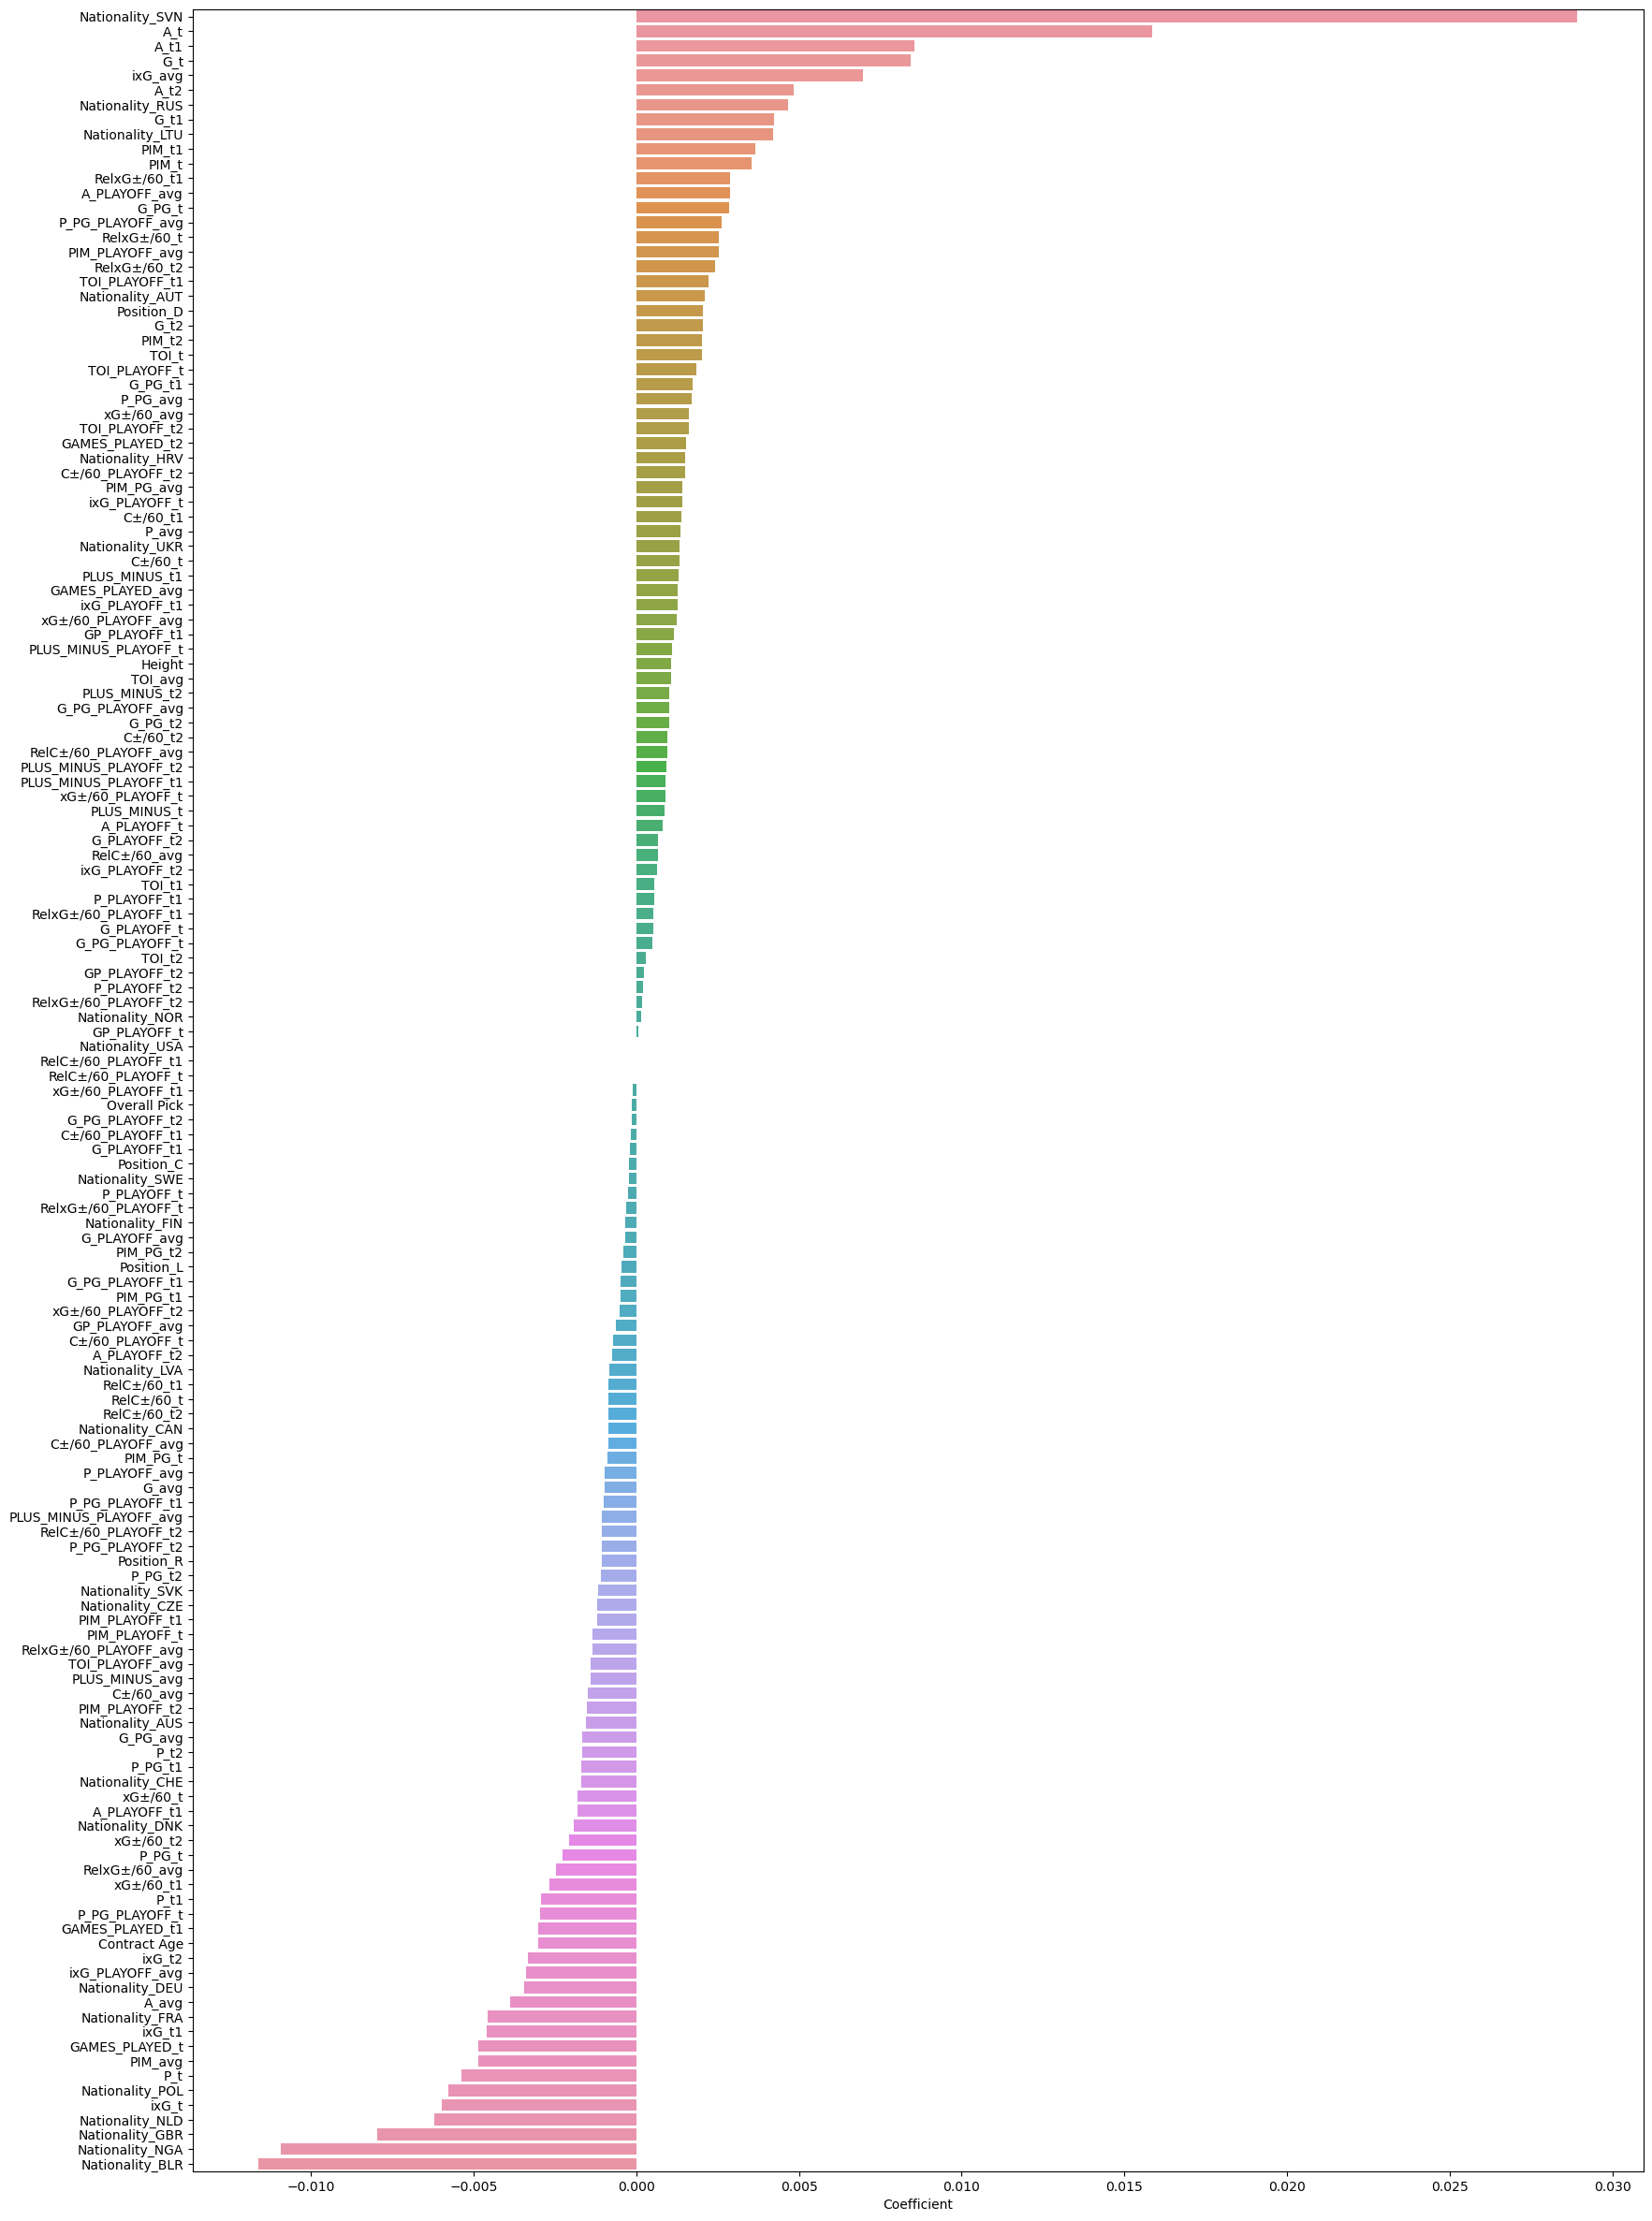

In [300]:
# get coefficients chart
eln_coef = pd.DataFrame(pd.Series(eln_final.coef_,index=eln_final.feature_names_in_)).sort_values(by=0,ascending=False)
eln_coef.columns = ['Coefficient']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=eln_coef.index,x=eln_coef['Coefficient']);

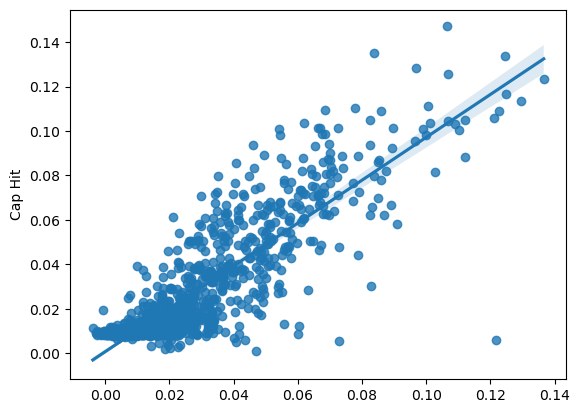

In [301]:
# plot true values vs residuals
sns.regplot(x=eln_predict,y=y_test);

Of interest regarding the elastic net model is that it performs basically as well as the ridge regression out-of-sample, though
it counts player position as more important predictors than the ridge regression.

#### Decision Tree Regression

In [180]:
# initialize Decision Tree Regression
dtr = DecisionTreeRegressor(random_state=100)
dtr_parameters_1 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                    'splitter': ['best','random'],
                    'max_depth':[1,5,10,20],
                    'min_samples_split':[1,3,5,7],
                    'max_features':['auto','sqrt','log2']}

In [181]:
# perform grid search
gs_dtr_1 = GridSearchCV(dtr,dtr_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_dtr_1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 3, 5, 7],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=False)

In [183]:
gs_dtr_1.best_score_

-0.007392916131112748

In [184]:
gs_dtr_1.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 1,
 'splitter': 'best'}

In [185]:
# enhance grid search
dtr_parameters_2 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                    'splitter': ['best','random'],
                    'max_depth':[2,5,8],
                    'min_samples_split':[1,3,5],
                    'max_features':['auto','sqrt','log2']}
gs_dtr_2 = GridSearchCV(dtr,dtr_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_dtr_2.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [2, 5, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 3, 5],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=False)

In [186]:
gs_dtr_2.best_score_

-0.007392916131112748

In [187]:
gs_dtr_2.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 1,
 'splitter': 'best'}

In [188]:
# build final model using best params
dtr_final = DecisionTreeRegressor(criterion = 'absolute_error',
                                  splitter = 'best',
                                  max_features = 'auto',
                                  max_depth = 5,
                                  min_samples_split = 1,
                                  random_state = 100)
dtr_final.fit(X_train,y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      max_features='auto', min_samples_split=1,
                      random_state=100)

In [189]:
# get final model error
dtr_predict = dtr_final.predict(X_test)
dtr_final_mae = mean_absolute_error(dtr_final.predict(X_test),y_test)
dtr_final_mae

0.007317235016852512

In [190]:
# add eln mae to dataframe
cap_hit_error.loc['Decision Tree Regression','Contract Annual Value'] = dtr_final_mae
cap_hit_error

MAE
Ridge Regression          0.008159
LASSO Regression          0.009368
Elastic Net Regression    0.008190
Decision Tree Regression  0.007317

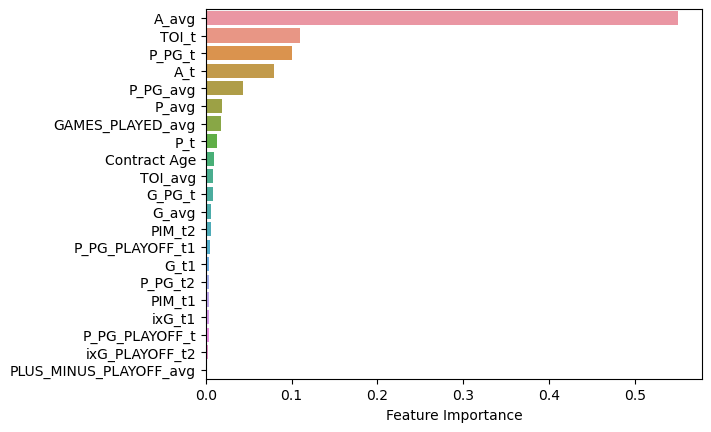

In [196]:
# get feature importance chart
dtr_featureImportance = pd.DataFrame(pd.Series(dtr_final.feature_importances_,
                                               index=dtr_final.feature_names_in_)).sort_values(by=0,ascending=False)
dtr_featureImportance.columns = ['Feature Importance']
dtr_featureImportance_sub = dtr_featureImportance[dtr_featureImportance['Feature Importance'] != 0]
sns.barplot(y=dtr_featureImportance_sub.index,x=dtr_featureImportance_sub['Feature Importance']);

In [ ]:
The decision tree regression was the best performing model yet. Like the other models, it highlight assists over the reviewed period and in the contract year as important, but it also considers points per game and time on ice to be important predictors as well.

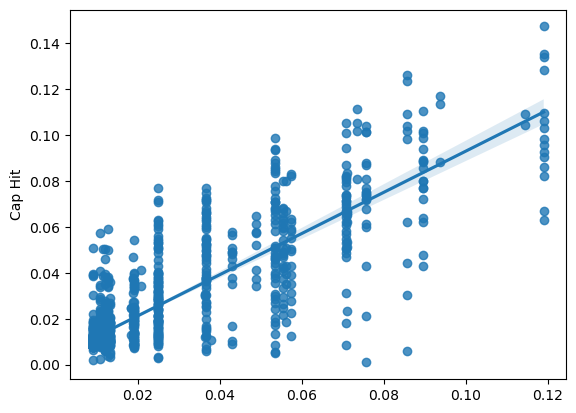

In [197]:
# plot true values vs residuals
sns.regplot(x=dtr_predict,y=y_test);

#### Random Forest Regression

In [219]:
# initialize Decision Tree Regression
rfr = RandomForestRegressor(random_state=100)
rfr_parameters_1 = {'n_estimators':[50,100,150]}

In [220]:
# perform grid search
gs_rfr_1 = GridSearchCV(rfr,rfr_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_rfr_1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
             param_grid={'n_estimators': [50, 100, 150]},
             scoring='neg_mean_absolute_error', verbose=False)

In [243]:
gs_rfr_1.best_score_

-0.006147825170372977

In [223]:
gs_rfr_1.best_params_

{'n_estimators': 150}

In [225]:
# enhance grid search
rfr_parameters_2 = {'n_estimators':[150,200,250]}
gs_rfr_2 = GridSearchCV(rfr,rfr_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_rfr_2.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
             param_grid={'n_estimators': [150, 200, 250]},
             scoring='neg_mean_absolute_error', verbose=False)

In [244]:
gs_rfr_2.best_score_

-0.006143060815217441

In [226]:
gs_rfr_2.best_params_

{'n_estimators': 200}

In [230]:
# build final model using best params
rfr_final = RandomForestRegressor(n_estimators=200,random_state=100)
rfr_final.fit(X_train,y_train)

RandomForestRegressor(n_estimators=200, random_state=100)

In [231]:
# get final model error
rfr_predict = rfr_final.predict(X_test)
rfr_final_mae = mean_absolute_error(rfr_final.predict(X_test),y_test)
rfr_final_mae

0.005912468368797356

In [232]:
# add rfr mae to dataframe
cap_hit_error.loc['Random Forest Regression','Contract Annual Value'] = rfr_final_mae
cap_hit_error

MAE
Ridge Regression          0.008159
LASSO Regression          0.009368
Elastic Net Regression    0.008190
Decision Tree Regression  0.007317
Random Forest Regression  0.005912

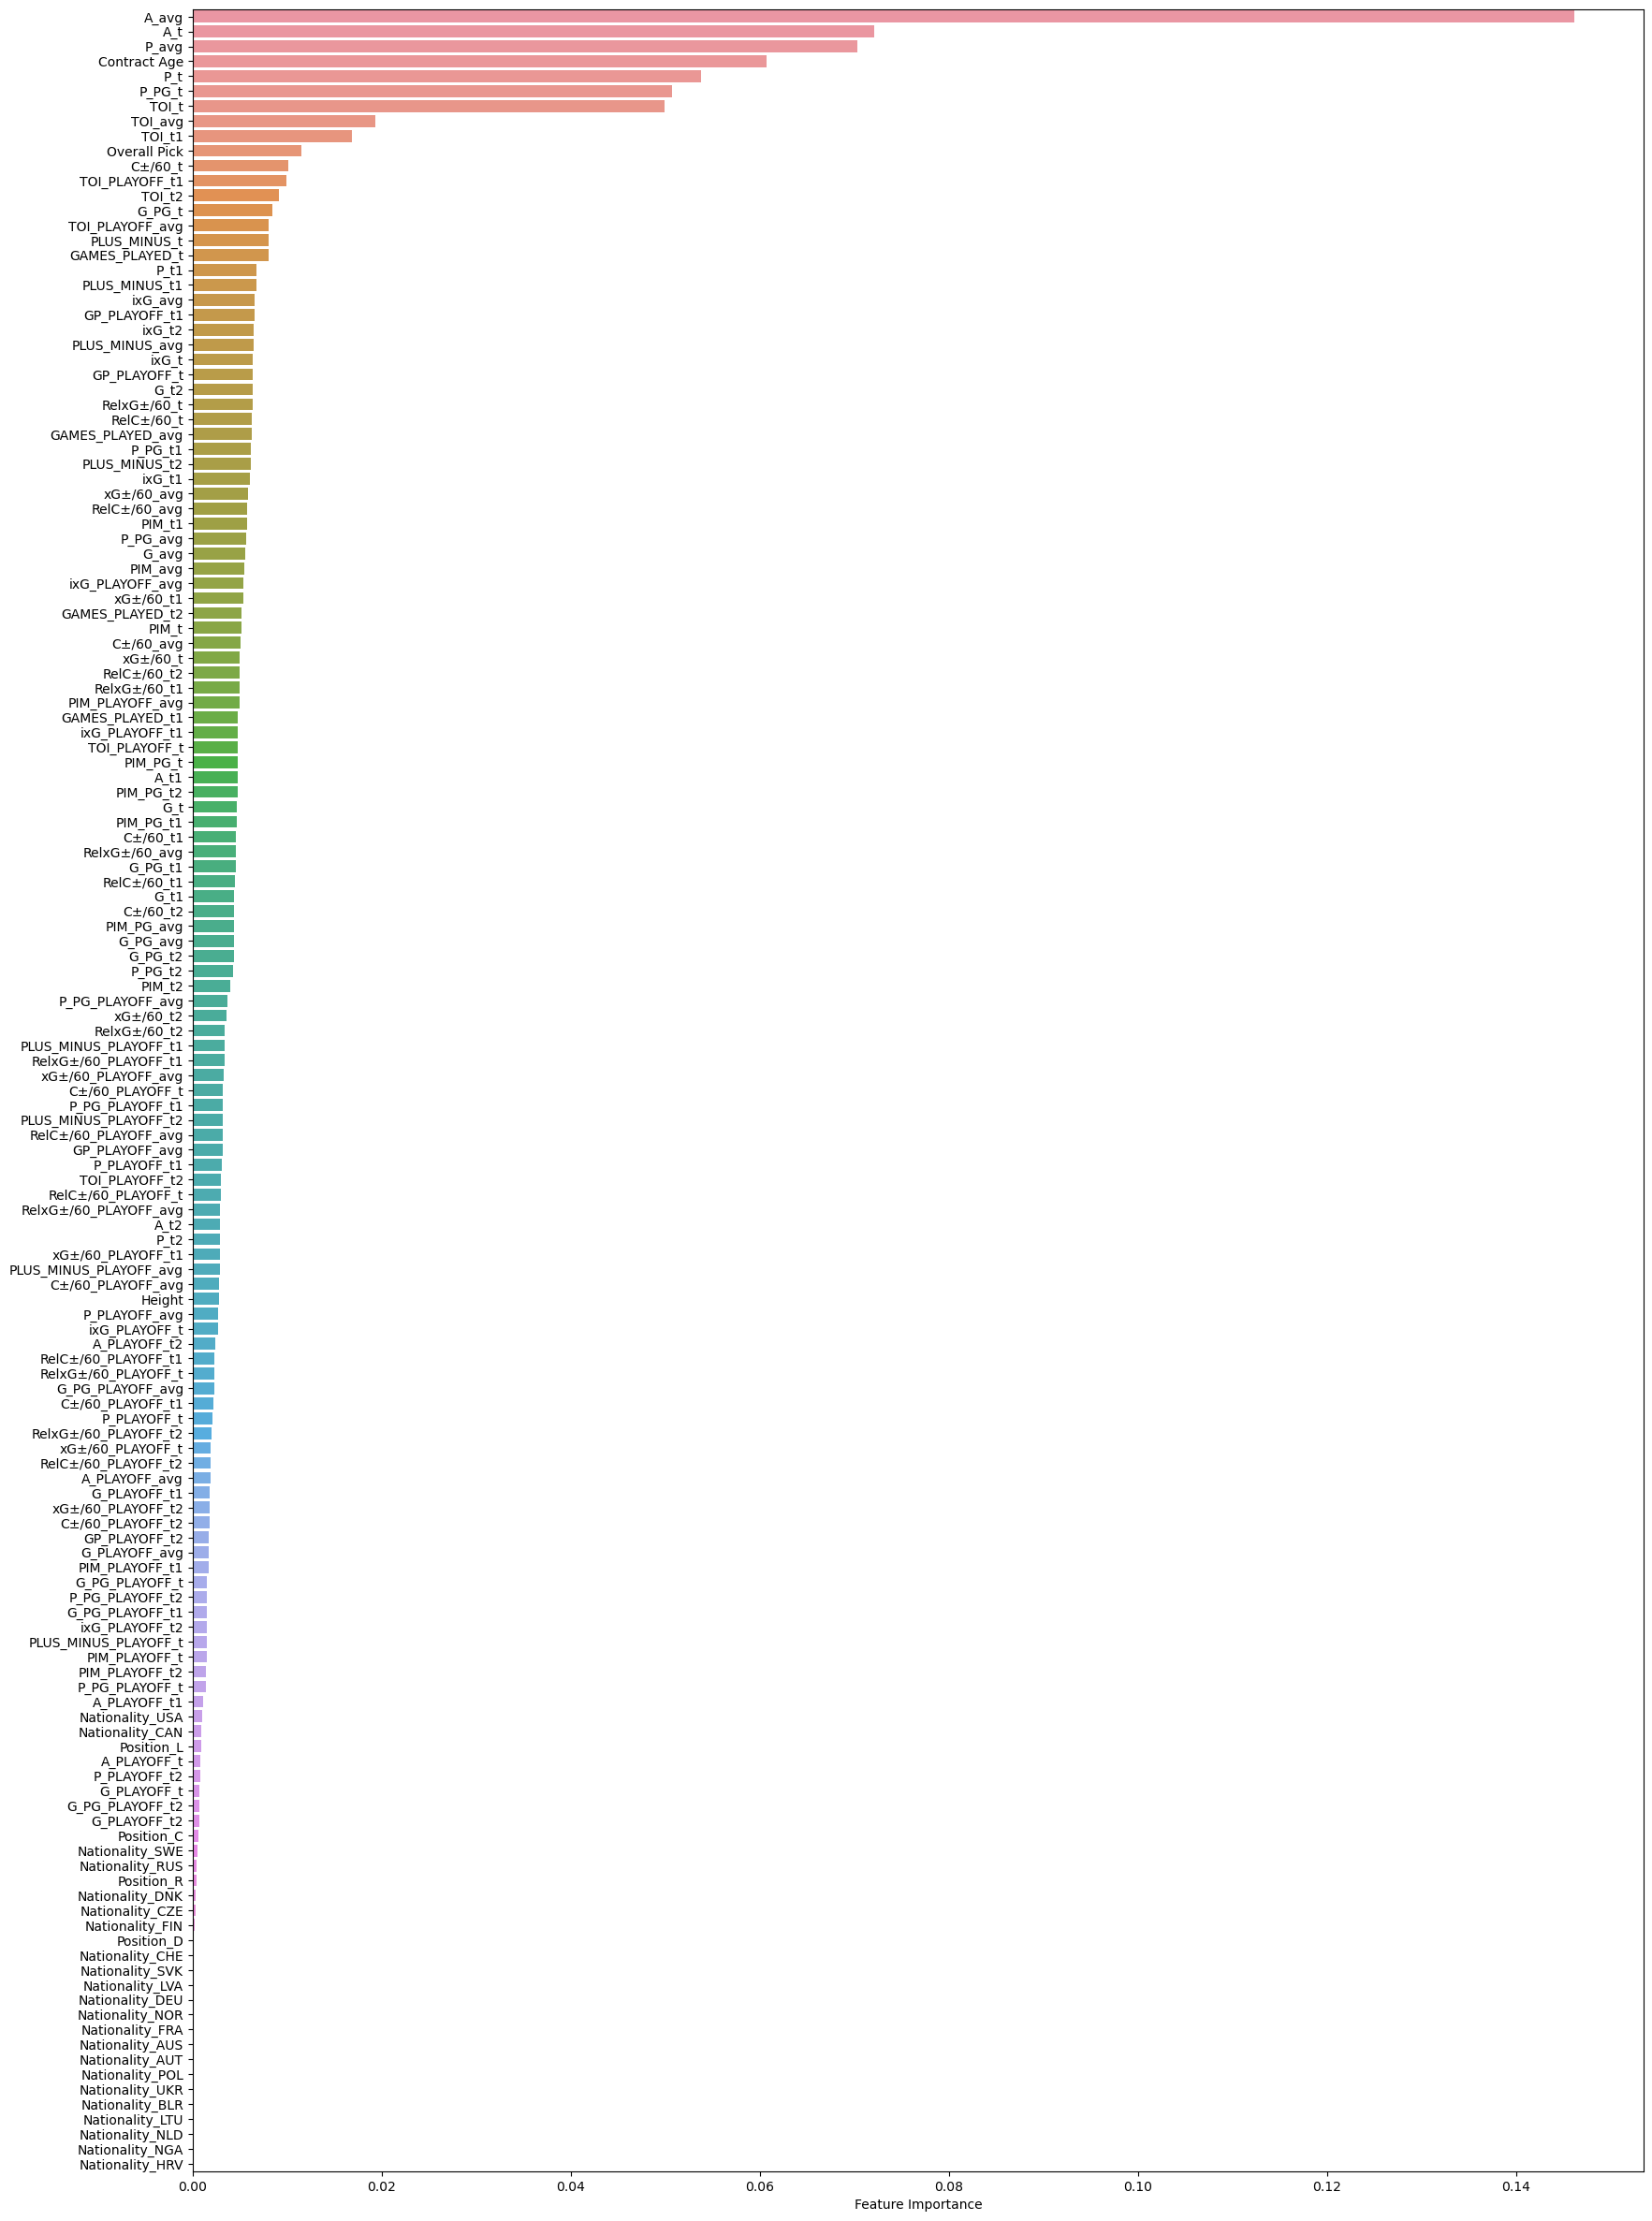

In [342]:
# get feature importance chart
rfr_featureImportance = pd.DataFrame(pd.Series(rfr_final.feature_importances_,
                                               index=rfr_final.feature_names_in_)).sort_values(by=0,ascending=False)
rfr_featureImportance.columns = ['Feature Importance']
rfr_featureImportance_sub = rfr_featureImportance[rfr_featureImportance['Feature Importance'] != 0]
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=rfr_featureImportance_sub.index,x=rfr_featureImportance_sub['Feature Importance']);

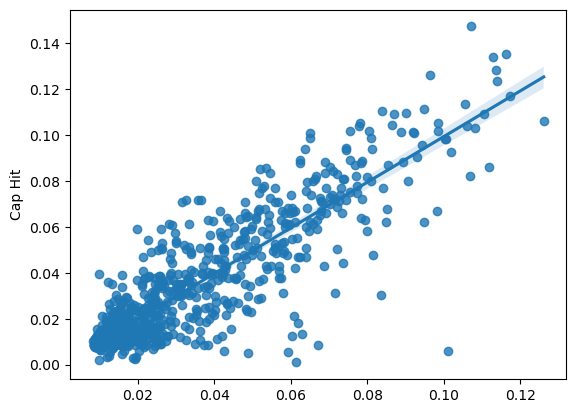

In [237]:
# plot true values vs residuals
sns.regplot(x=rfr_predict,y=y_test);

Looking at the feature importances in the random forest regression, we can see that the top ones are similar to those of decision tree regression, namely assists and points per game.

#### XGBoost Regression

In [240]:
# initialize XGBoost Regression
xgbr = XGBRegressor(random_state=100)
xgbr_parameters_1 = {'learning_rate': [0.05,0.10,0.15],
                     'max_depth': [2,5,10],
                     'min_child_weight': [1,3,5],
                     'n_estimators': [20,40,80],
                     'tree_method': ['exact','approx','hist']}

In [241]:
# perform grid search
gs_xgbr_1 = GridSearchCV(xgbr,xgbr_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 5, 10], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [20, 40, 80],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='neg_mean_absolute_error', verbose=False)

In [246]:
gs_xgbr_1.best_score_

-0.006111363067977107

In [242]:
gs_xgbr_1.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 80,
 'tree_method': 'approx'}

In [248]:
# enhance grid search
xgbr_parameters_2 = {'learning_rate': [0.10],
                     'max_depth': [5,10,15],
                     'min_child_weight': [3,5,8],
                     'n_estimators': [50,80,100],
                     'tree_method': ['exact','approx']}
gs_xgbr_2 = GridSearchCV(xgbr,xgbr_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [5, 10, 15],
                         'min_child_weight': [3, 5, 8],
                         'n_estimators': [50, 80, 100],
                         'tree_method': ['exact', 'approx']},
             scoring='neg_mean_absolute_error', verbose=False)

In [249]:
gs_xgbr_2.best_score_

-0.006077865768883623

In [250]:
gs_xgbr_2.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 8,
 'n_estimators': 100,
 'tree_method': 'approx'}

In [251]:
# enhance grid search
xgbr_parameters_3 = {'learning_rate': [0.10],
                     'max_depth': [8,10,12],
                     'min_child_weight': [5,8,12],
                     'n_estimators': [80,100,120],
                     'tree_method': ['exact','approx']}
gs_xgbr_3 = GridSearchCV(xgbr,xgbr_parameters_3,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8, 10, 12],
                         'min_child_weight': [5, 8, 12],
                         'n_estimators': [80, 100, 120],
                         'tree_method': ['exact', 'approx']},
             scoring='neg_mean_absolute_error', verbose=False)

In [252]:
gs_xgbr_3.best_score_

-0.006031162522949796

In [253]:
gs_xgbr_3.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 8,
 'n_estimators': 100,
 'tree_method': 'approx'}

In [254]:
# enhance grid search
xgbr_parameters_4 = {'learning_rate': [0.10],
                     'max_depth': [6,8,10],
                     'min_child_weight': [5,8,10],
                     'n_estimators': [85,100,115],
                     'tree_method': ['exact','approx']}
gs_xgbr_4 = GridSearchCV(xgbr,xgbr_parameters_4,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_4.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [6, 8, 10],
                         'min_child_weight': [5, 8, 10],
                         'n_estimators': [85, 100, 115],
                         'tree_method': ['exact', 'approx']},
             scoring='neg_mean_absolute_error', verbose=False)

In [255]:
gs_xgbr_4.best_score_

-0.006007341194991784

In [256]:
gs_xgbr_4.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 10,
 'n_estimators': 115,
 'tree_method': 'approx'}

In [43]:
# build final model using best params
xgbr_final = XGBRegressor(learning_rate=0.1,
                          max_depth=8,
                          min_child_weight=10,
                          n_estimators=115,
                          tree_method='approx',
                          random_state=100)
xgbr_final.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=115, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=100, ...)

In [258]:
# get final model error
xgbr_predict = xgbr_final.predict(X_test)
xgbr_final_mae = mean_absolute_error(xgbr_final.predict(X_test),y_test)
xgbr_final_mae

0.005765230725469842

In [259]:
# add xgbr mae to dataframe
cap_hit_error.loc['XGBoost Regression','Contract Annual Value'] = xgbr_final_mae
cap_hit_error

MAE
Ridge Regression          0.008159
LASSO Regression          0.009368
Elastic Net Regression    0.008190
Decision Tree Regression  0.007317
Random Forest Regression  0.005912
XGBoost Regression        0.005765

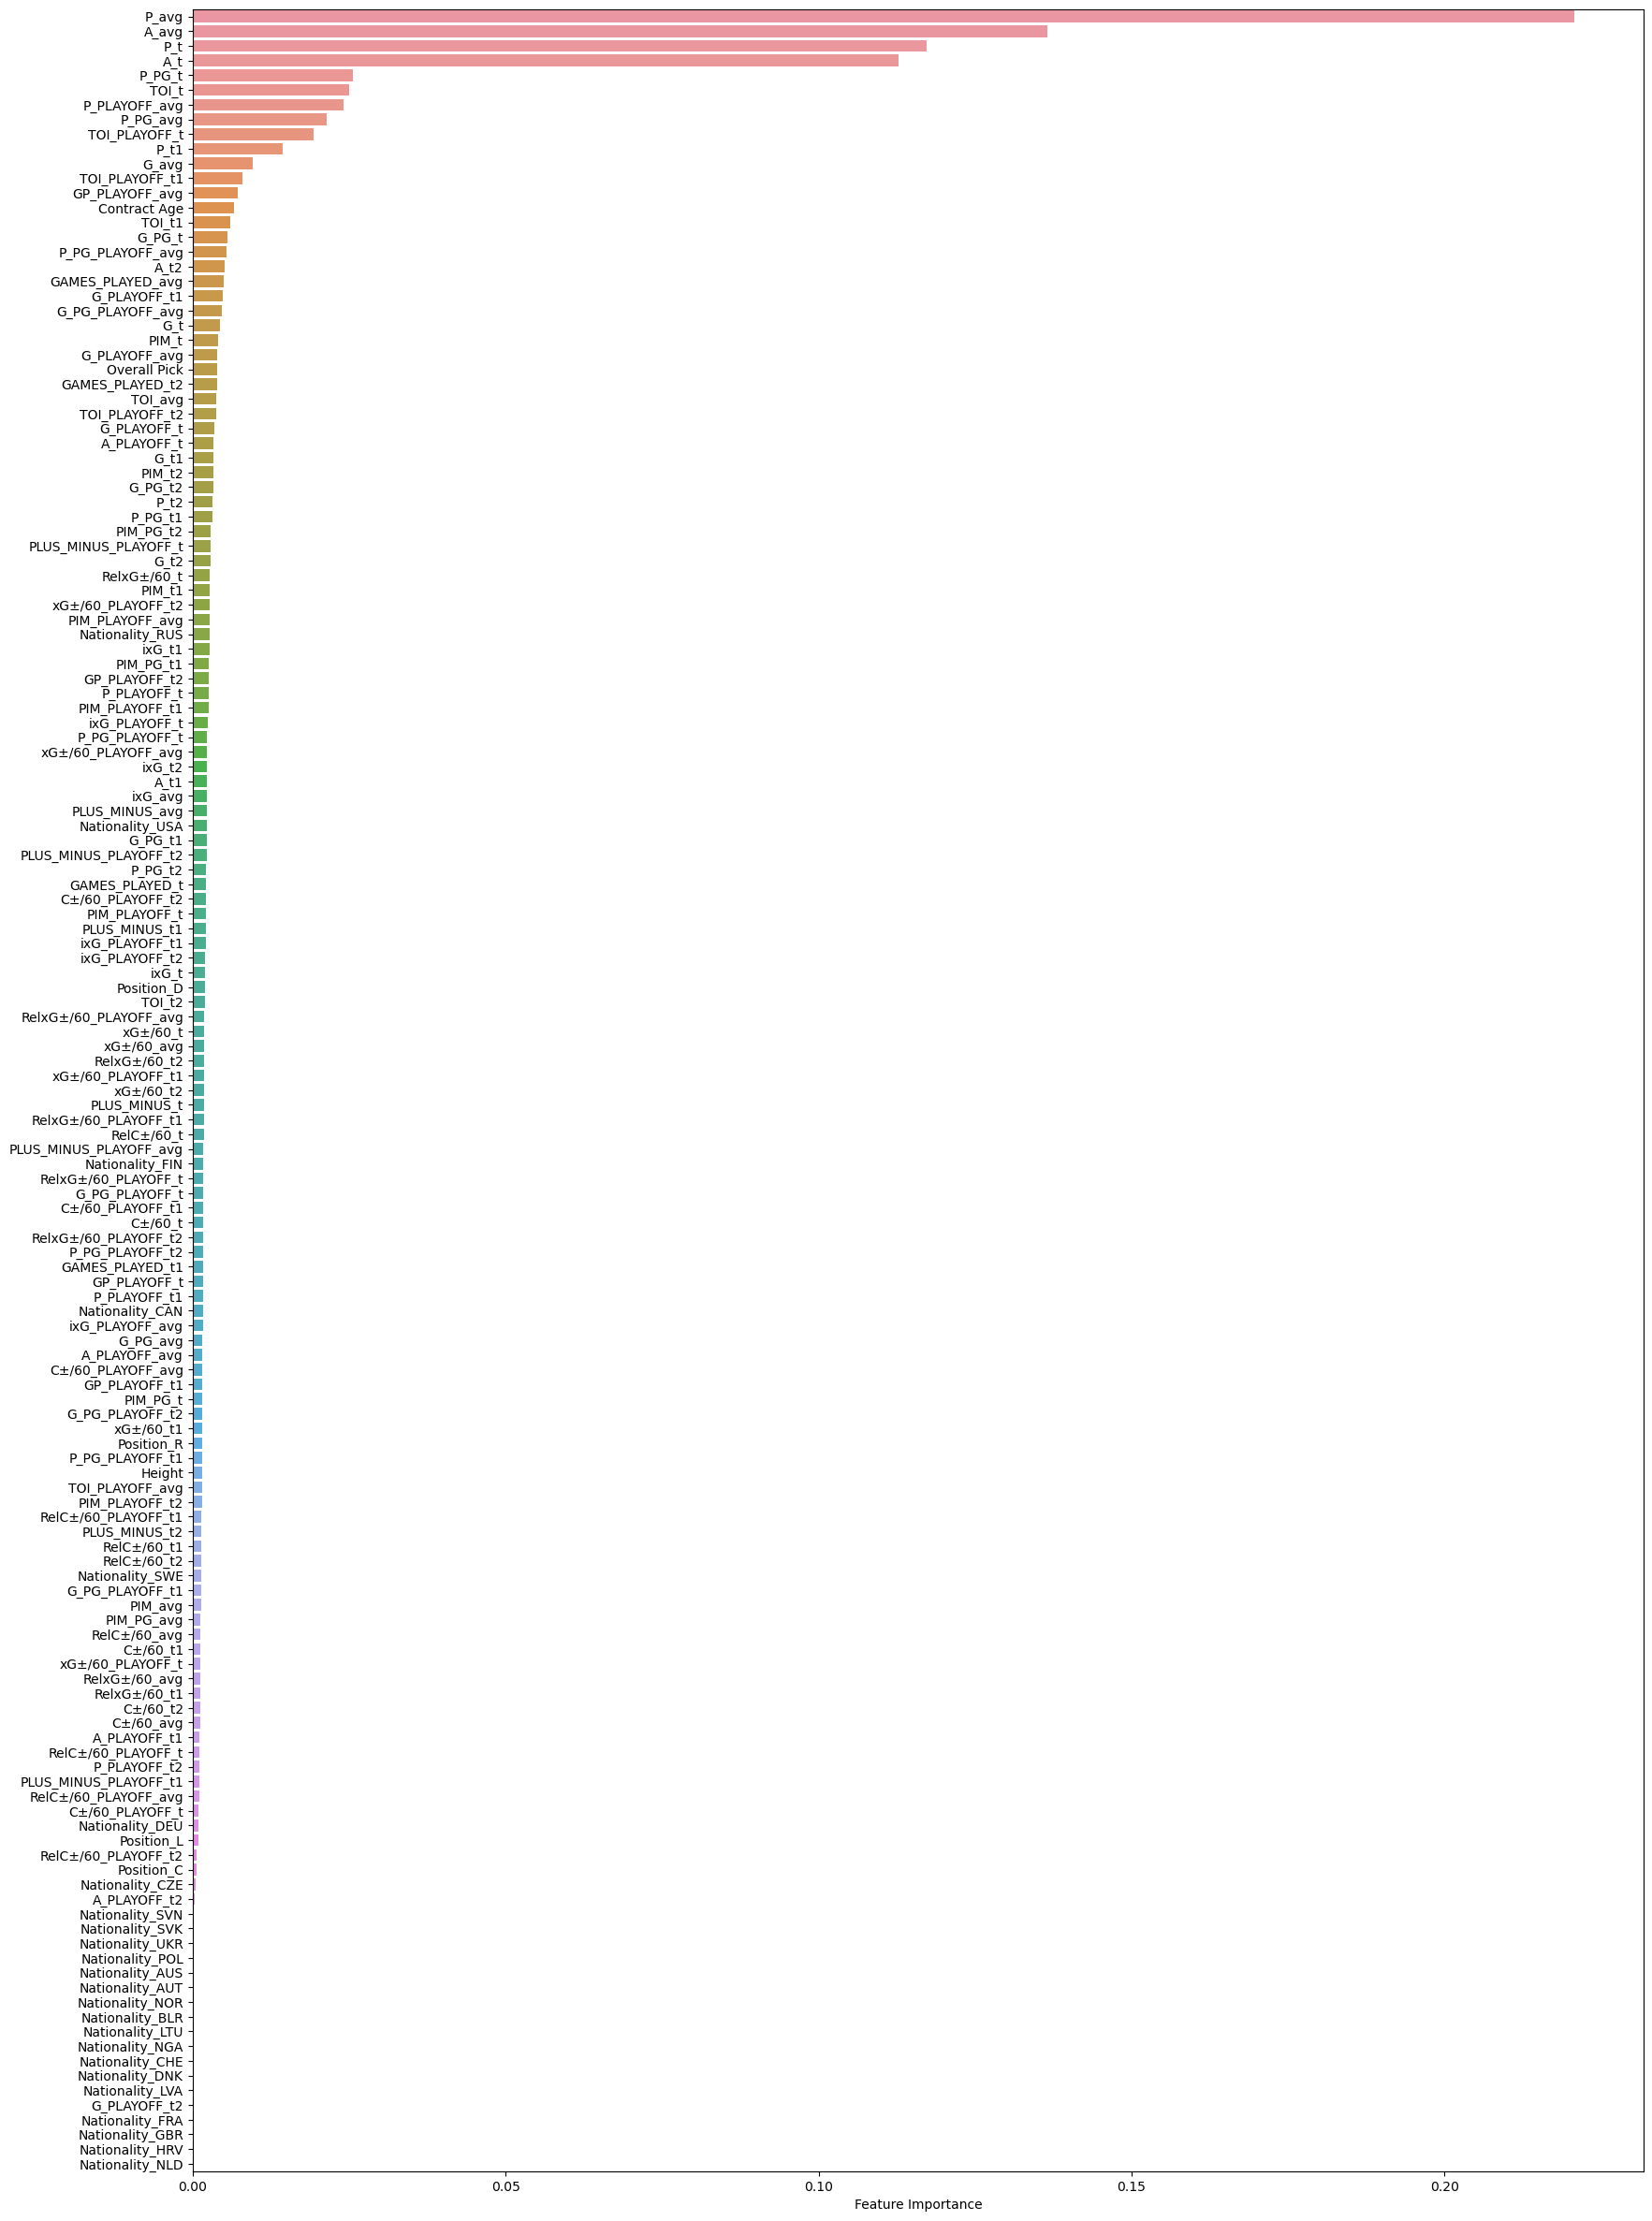

In [260]:
# get feature importance chart
xgbr_featureImportance = pd.DataFrame(pd.Series(xgbr_final.feature_importances_,
                                                index=xgbr_final.feature_names_in_)).sort_values(by=0,ascending=False)
xgbr_featureImportance.columns = ['Feature Importance']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=xgbr_featureImportance.index,x=xgbr_featureImportance['Feature Importance']);

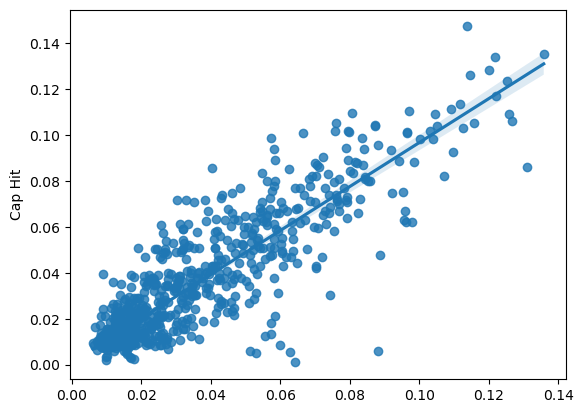

In [262]:
# plot true values vs residuals
sns.regplot(x=xgbr_predict,y=y_test);

Looking at feature importance for the XGBoost regression, which has the best out-of-sample MAE of all models considered, we see that the most important features are in line with what the other models have suggested: points and assists, followed by points per game and time on ice.

### Contract Length Modelling

#### Ridge Regression

In [263]:
# initialize ridge regression and parameters
ridge_l = linear_model.Ridge(random_state=100)
ridge_l_parameters = {'alpha': np.concatenate((np.arange(0.005,2,0.005),np.arange(2,5,0.5),np.arange(5,25,1))),
                      'positive': [True,False],
                      'fit_intercept': [True,False]}

In [264]:
# perform grid search
gs_ridge_l = GridSearchCV(ridge_l,ridge_l_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_ridge_l.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=100),
             param_grid={'alpha': array([5.000e-03, 1.000e-02, 1.500e-02, 2.000e-02, 2.500e-02, 3.000e-02,
       3.500e-02, 4.000e-02, 4.500e-02, 5.000e-02, 5.500e-02, 6.000e-02,
       6.500e-02, 7.000e-02, 7.500e-02, 8.000e-02, 8.500e-02, 9.000e-02,
       9.500e-02, 1.000e-01, 1.050e-01, 1.100e-01, 1.150e-01, 1.200e-01,
       1.250e-01, 1.300e-01, 1.350e-01, 1...
       1.985e+00, 1.990e+00, 1.995e+00, 2.000e+00, 2.500e+00, 3.000e+00,
       3.500e+00, 4.000e+00, 4.500e+00, 5.000e+00, 6.000e+00, 7.000e+00,
       8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01,
       1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01, 1.800e+01, 1.900e+01,
       2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01, 2.400e+01]),
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_absolute_error', verbose=False)

In [265]:
gs_ridge_l.best_score_

-0.8815634187880115

In [266]:
gs_ridge_l.best_params_

{'alpha': 24.0, 'fit_intercept': True, 'positive': False}

In [267]:
# build final model using best params
ridge_l_final = linear_model.Ridge(alpha=24,fit_intercept=True,positive=False,random_state=100)
ridge_l_final.fit(X_train,y_l_train)

Ridge(alpha=24, random_state=100)

In [268]:
# get final model error
ridge_l_predict = ridge_l_final.predict(X_test)
ridge_l_final_mae = mean_absolute_error(ridge_l_final.predict(X_test),y_l_test)
ridge_l_final_mae

0.8604984256383817

In [269]:
# add ridge mae to dataframe
cap_hit_error.loc['Ridge Regression','Contract Length'] = ridge_l_final_mae
cap_hit_error

MAE  Contract Length
Ridge Regression          0.008159         0.860498
LASSO Regression          0.009368              NaN
Elastic Net Regression    0.008190              NaN
Decision Tree Regression  0.007317              NaN
Random Forest Regression  0.005912              NaN
XGBoost Regression        0.005765              NaN

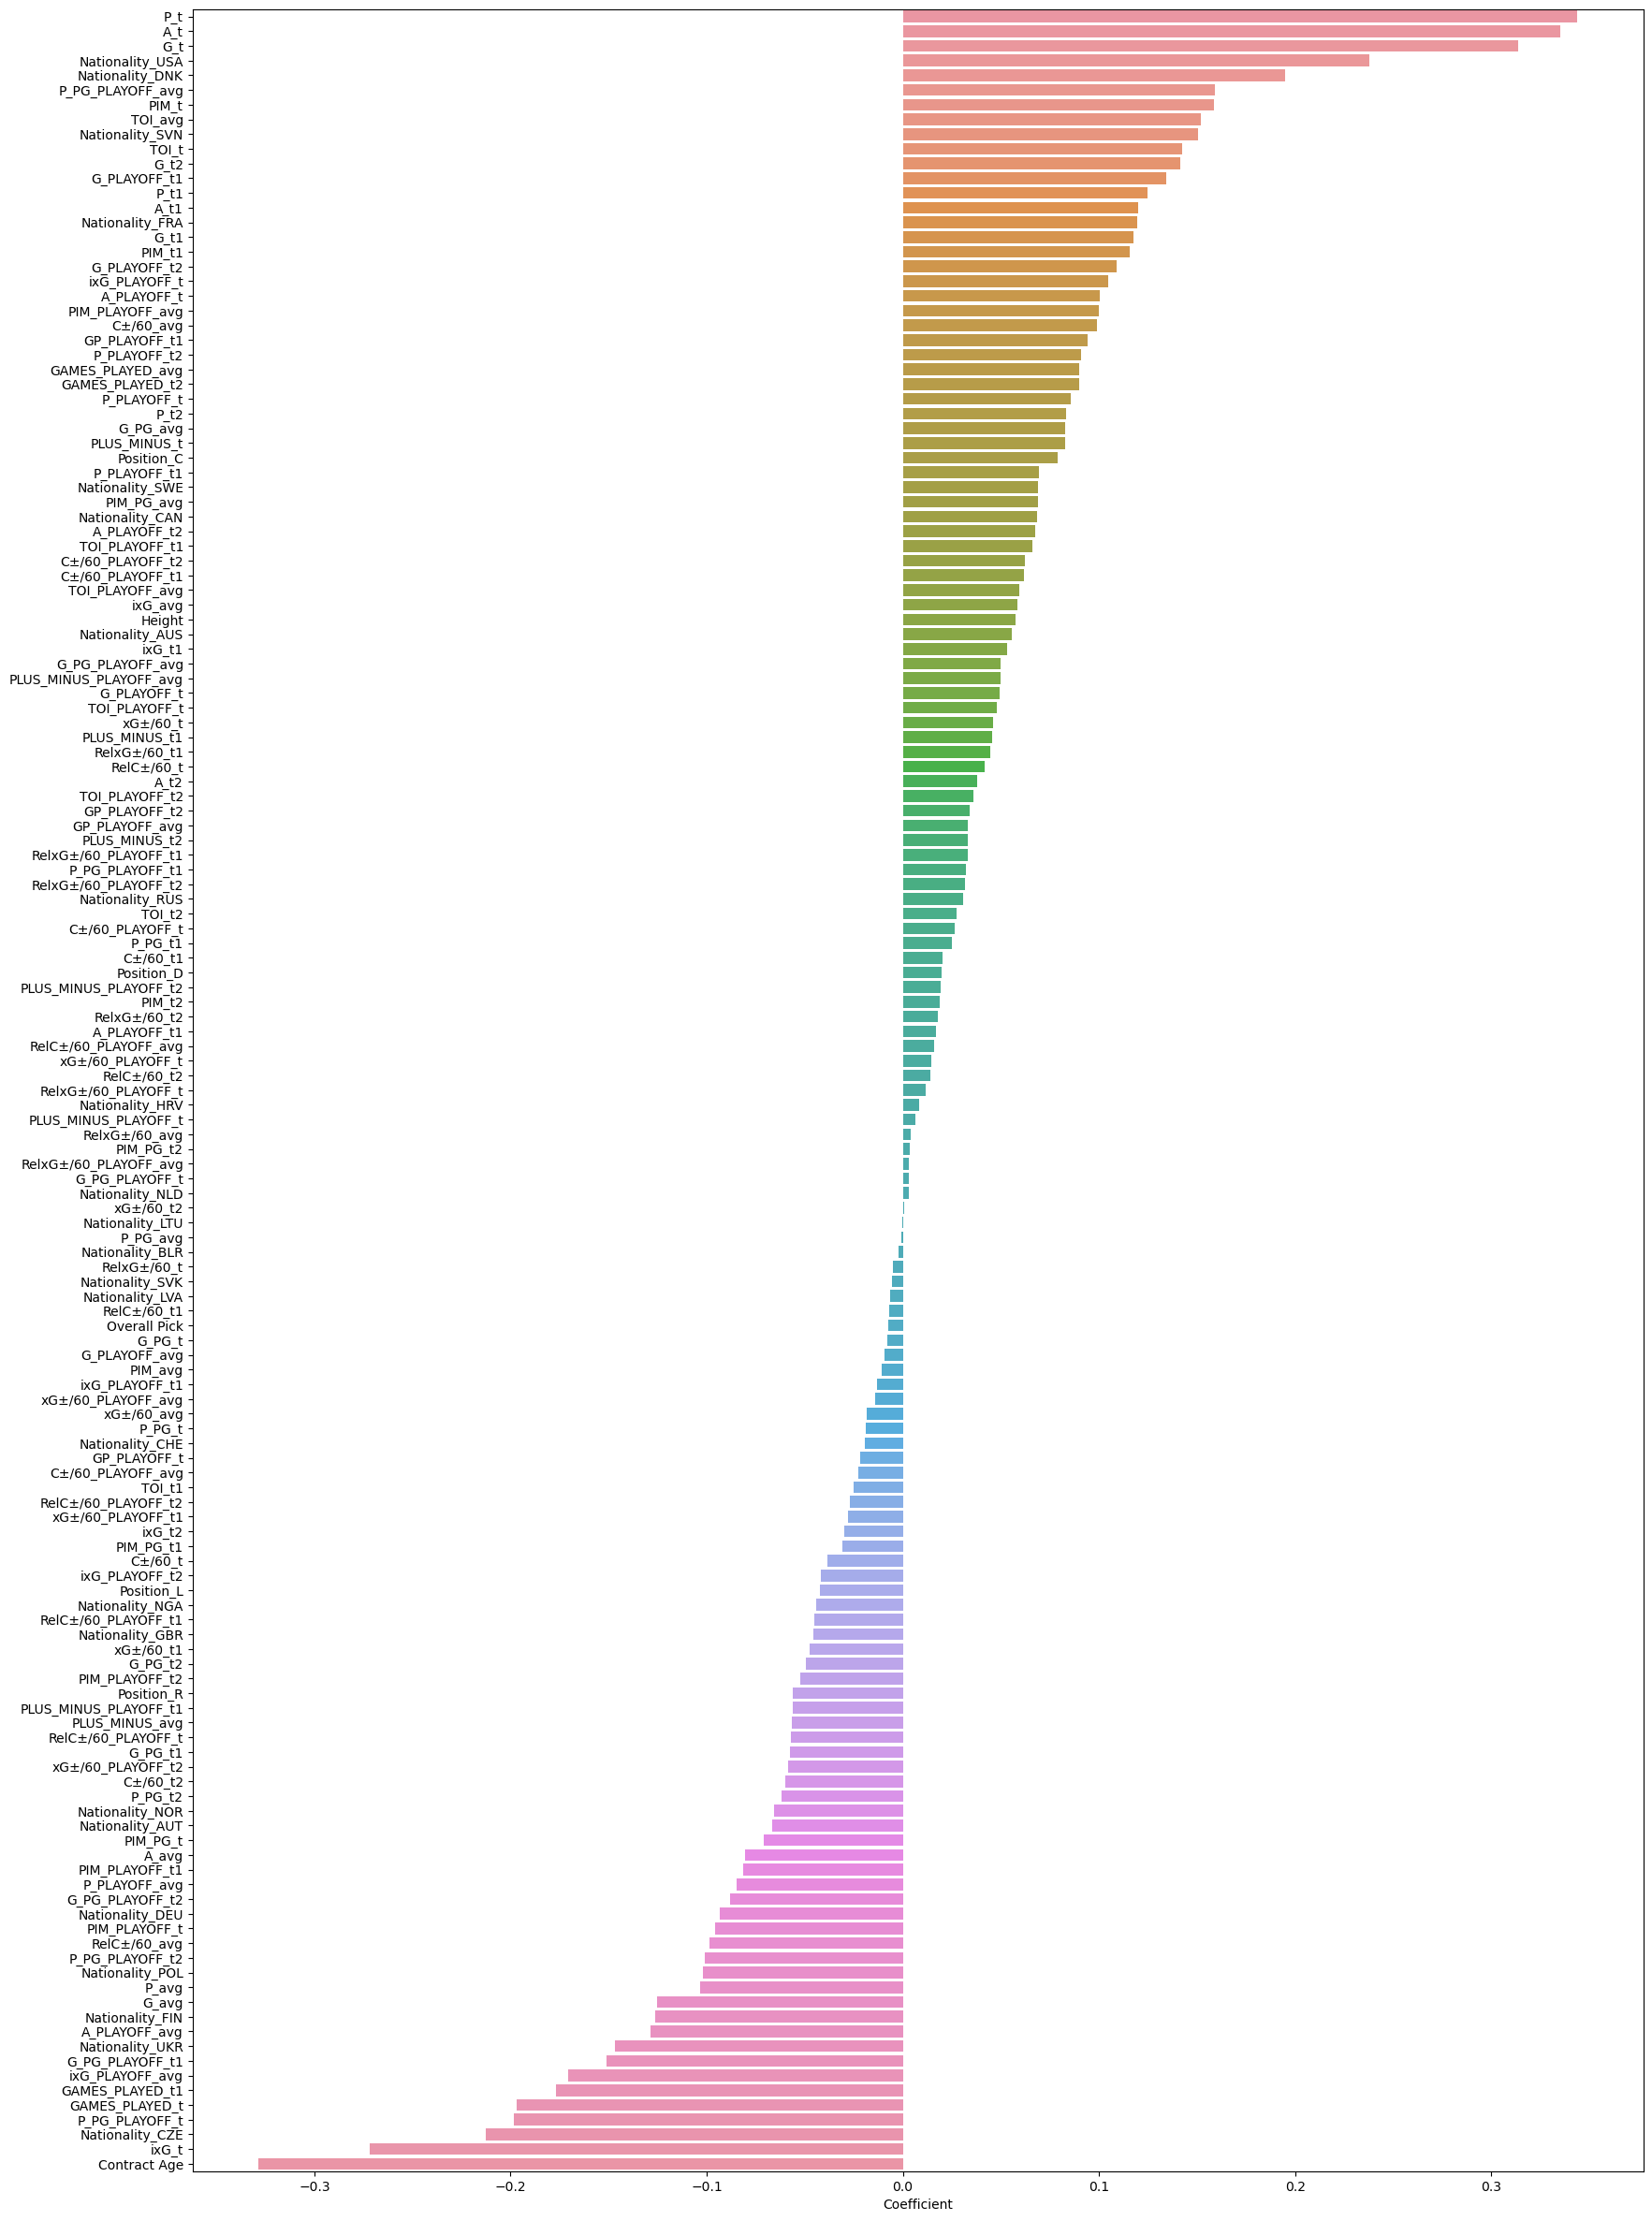

In [270]:
# get coefficients chart
ridge_l_coef = pd.DataFrame(pd.Series(ridge_l_final.coef_,
                                      index=ridge_l_final.feature_names_in_)).sort_values(by=0,ascending=False)
ridge_l_coef.columns = ['Coefficient']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=ridge_l_coef.index,x=ridge_l_coef['Coefficient']);

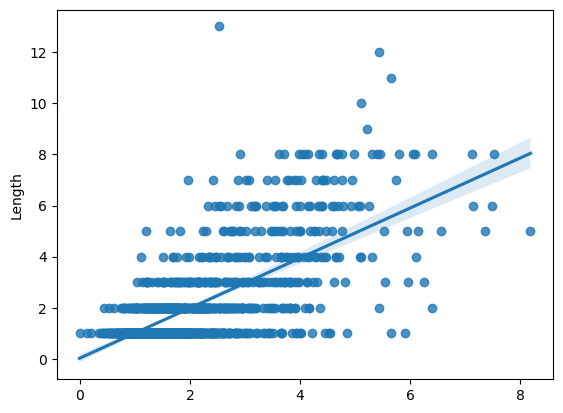

In [271]:
# plot true values vs residuals
sns.regplot(x=ridge_l_predict,y=y_l_test);

#### LASSO

In [273]:
# initialize LASSO
lasso_l = linear_model.Lasso(random_state=100)
lasso_l_parameters = {'alpha': np.concatenate((np.arange(0.005,2,0.005),np.arange(2,5,0.5),np.arange(5,25,1))),
                      'positive': [True,False],
                      'fit_intercept': [True,False]}

In [278]:
# perform grid search
gs_l_lasso = GridSearchCV(lasso_l,lasso_l_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_l_lasso.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=Lasso(random_state=100),
             param_grid={'alpha': array([5.000e-03, 1.000e-02, 1.500e-02, 2.000e-02, 2.500e-02, 3.000e-02,
       3.500e-02, 4.000e-02, 4.500e-02, 5.000e-02, 5.500e-02, 6.000e-02,
       6.500e-02, 7.000e-02, 7.500e-02, 8.000e-02, 8.500e-02, 9.000e-02,
       9.500e-02, 1.000e-01, 1.050e-01, 1.100e-01, 1.150e-01, 1.200e-01,
       1.250e-01, 1.300e-01, 1.350e-01, 1...
       1.985e+00, 1.990e+00, 1.995e+00, 2.000e+00, 2.500e+00, 3.000e+00,
       3.500e+00, 4.000e+00, 4.500e+00, 5.000e+00, 6.000e+00, 7.000e+00,
       8.000e+00, 9.000e+00, 1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01,
       1.400e+01, 1.500e+01, 1.600e+01, 1.700e+01, 1.800e+01, 1.900e+01,
       2.000e+01, 2.100e+01, 2.200e+01, 2.300e+01, 2.400e+01]),
                         'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_absolute_error', verbose=False)

In [279]:
gs_l_lasso.best_score_

-0.8686124500816603

In [280]:
gs_l_lasso.best_params_

{'alpha': 0.015, 'fit_intercept': False, 'positive': False}

In [283]:
# build final model using best params
lasso_l_final = linear_model.Lasso(alpha=0.005,fit_intercept=False,positive=False,random_state=100)
lasso_l_final.fit(X_train,y_l_train)

Lasso(alpha=0.005, fit_intercept=False, random_state=100)

In [284]:
# get final model error
lasso_l_predict = lasso_l_final.predict(X_test)
lasso_l_final_mae = mean_absolute_error(lasso_l_final.predict(X_test),y_l_test)
lasso_l_final_mae

0.854806576269839

In [285]:
# add lasso mae to dataframe
cap_hit_error.loc['LASSO Regression','Contract Length'] = lasso_l_final_mae
cap_hit_error

MAE  Contract Length
Ridge Regression          0.008159         0.860498
LASSO Regression          0.009368         0.854807
Elastic Net Regression    0.008190              NaN
Decision Tree Regression  0.007317              NaN
Random Forest Regression  0.005912              NaN
XGBoost Regression        0.005765              NaN

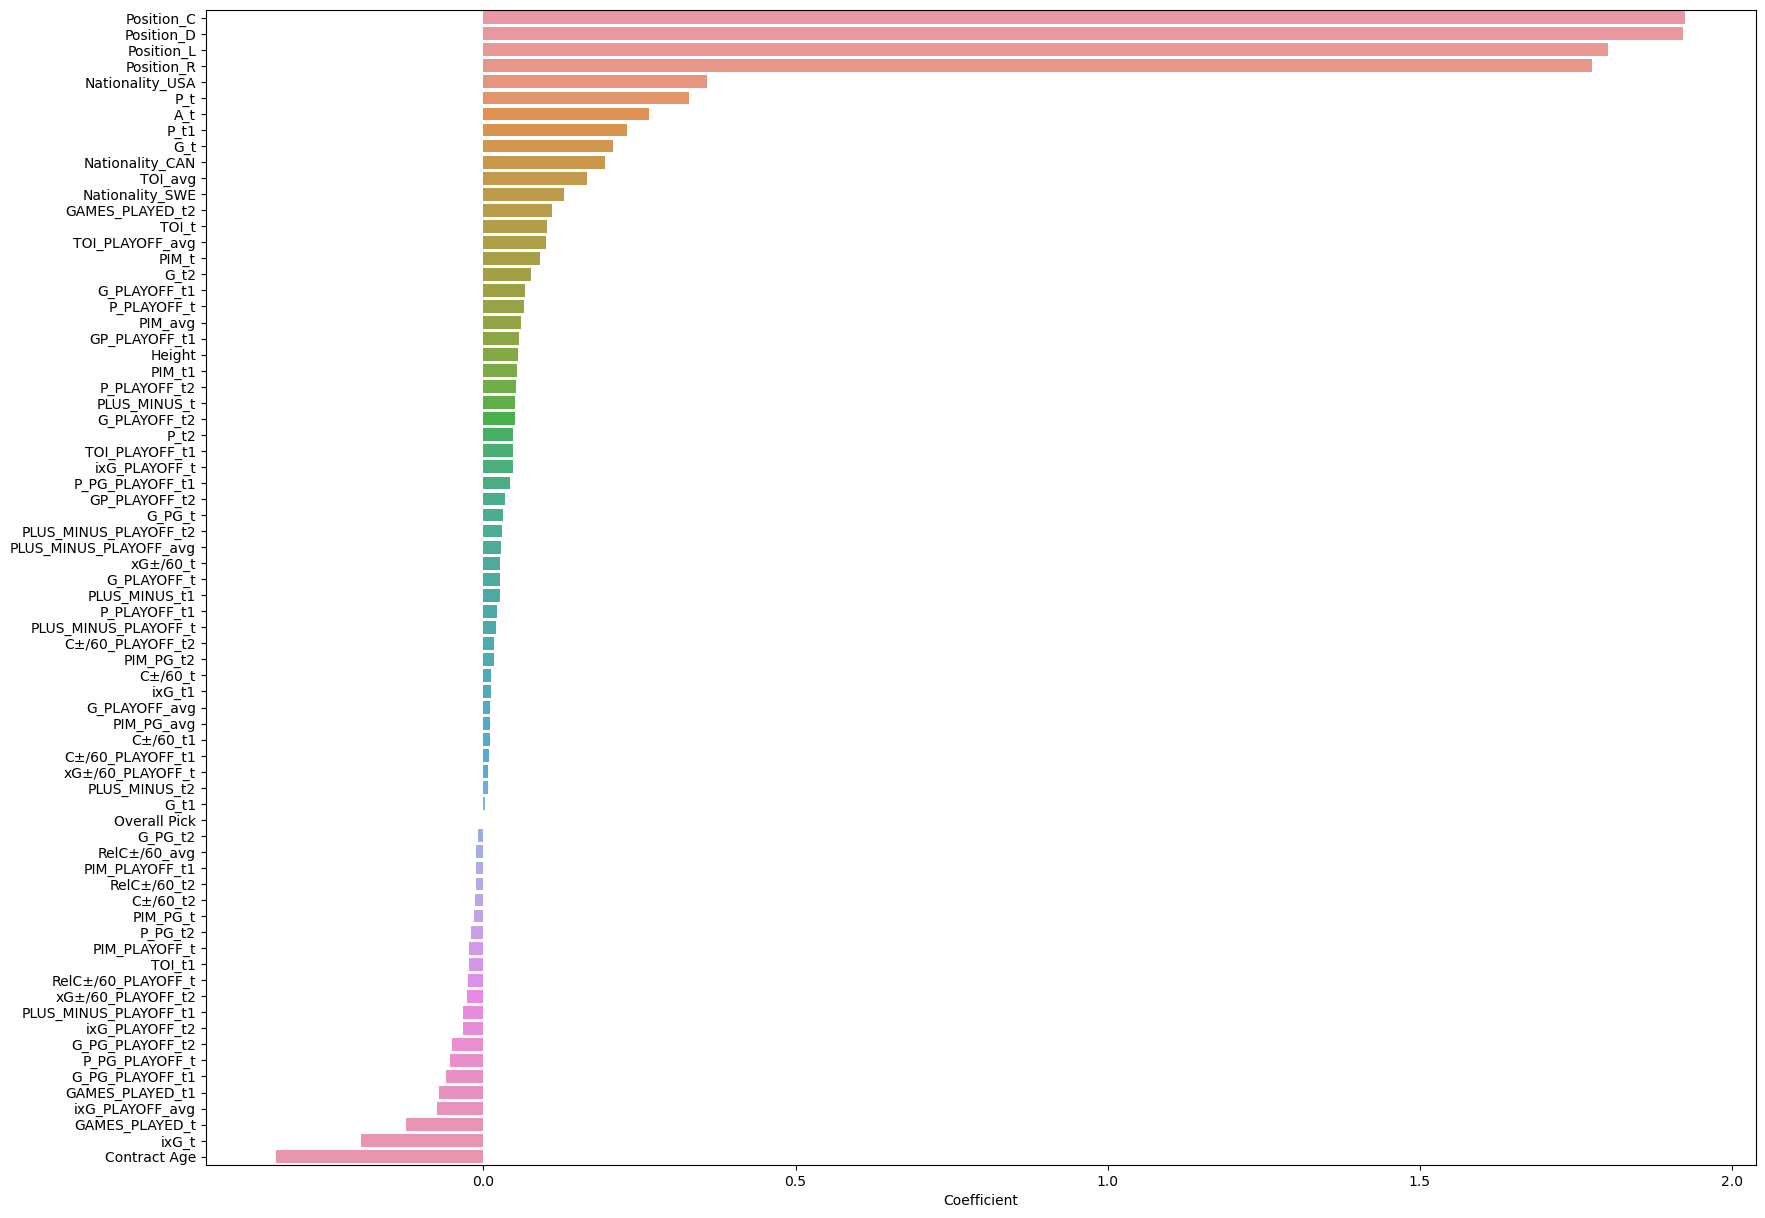

In [289]:
# get coefficients chart
lasso_l_coef = pd.DataFrame(pd.Series(lasso_l_final.coef_,
                                      index=lasso_l_final.feature_names_in_)).sort_values(by=0,ascending=False)
lasso_l_coef.columns = ['Coefficient']
lasso_l_coef_sub = lasso_l_coef[lasso_l_coef['Coefficient'] != 0]
fig,ax = plt.subplots(figsize=(20,15))
sns.barplot(y=lasso_l_coef_sub.index,x=lasso_l_coef_sub['Coefficient']);

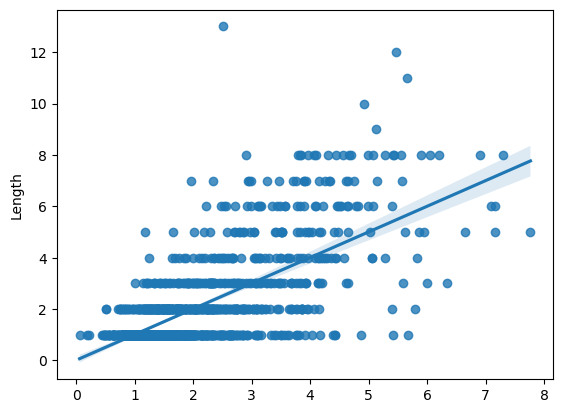

In [291]:
# plot true values vs residuals
sns.regplot(x=lasso_l_predict,y=y_l_test);

#### Elastic Net

In [302]:
# initialize Elastic Net
eln_l = linear_model.ElasticNet(random_state=100)
eln_l_parameters = {'alpha': np.arange(0,1,0.005),
                    'fit_intercept': [True,False]}

In [304]:
# perform grid search
gs_eln_l = GridSearchCV(eln_l,eln_l_parameters,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_eln_l.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=ElasticNet(random_state=100),
             param_grid={'alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0...
       0.72 , 0.725, 0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 ,
       0.765, 0.77 , 0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805,
       0.81 , 0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 ,
       0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895,
       0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 ,
       0.945, 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985,
       0.99 , 0.995]),
                         'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error', verbose=False)

In [305]:
gs_eln_l.best_score_

-0.8700390934273979

In [306]:
gs_eln_l.best_params_

{'alpha': 0.025, 'fit_intercept': True}

In [307]:
# build final model using best params
eln_l_final = linear_model.ElasticNet(alpha=0.025,fit_intercept=True,random_state=100)
eln_l_final.fit(X_train,y_l_train)

ElasticNet(alpha=0.025, random_state=100)

In [308]:
# get final model error
eln_l_predict = eln_l_final.predict(X_test)
eln_l_final_mae = mean_absolute_error(eln_l_final.predict(X_test),y_l_test)
eln_l_final_mae

0.8562603184012574

In [309]:
# add eln mae to dataframe
cap_hit_error.loc['Elastic Net Regression','Contract Length'] = eln_l_final_mae
cap_hit_error

MAE  Contract Length
Ridge Regression          0.008159         0.860498
LASSO Regression          0.009368         0.854807
Elastic Net Regression    0.008190         0.856260
Decision Tree Regression  0.007317              NaN
Random Forest Regression  0.005912              NaN
XGBoost Regression        0.005765              NaN

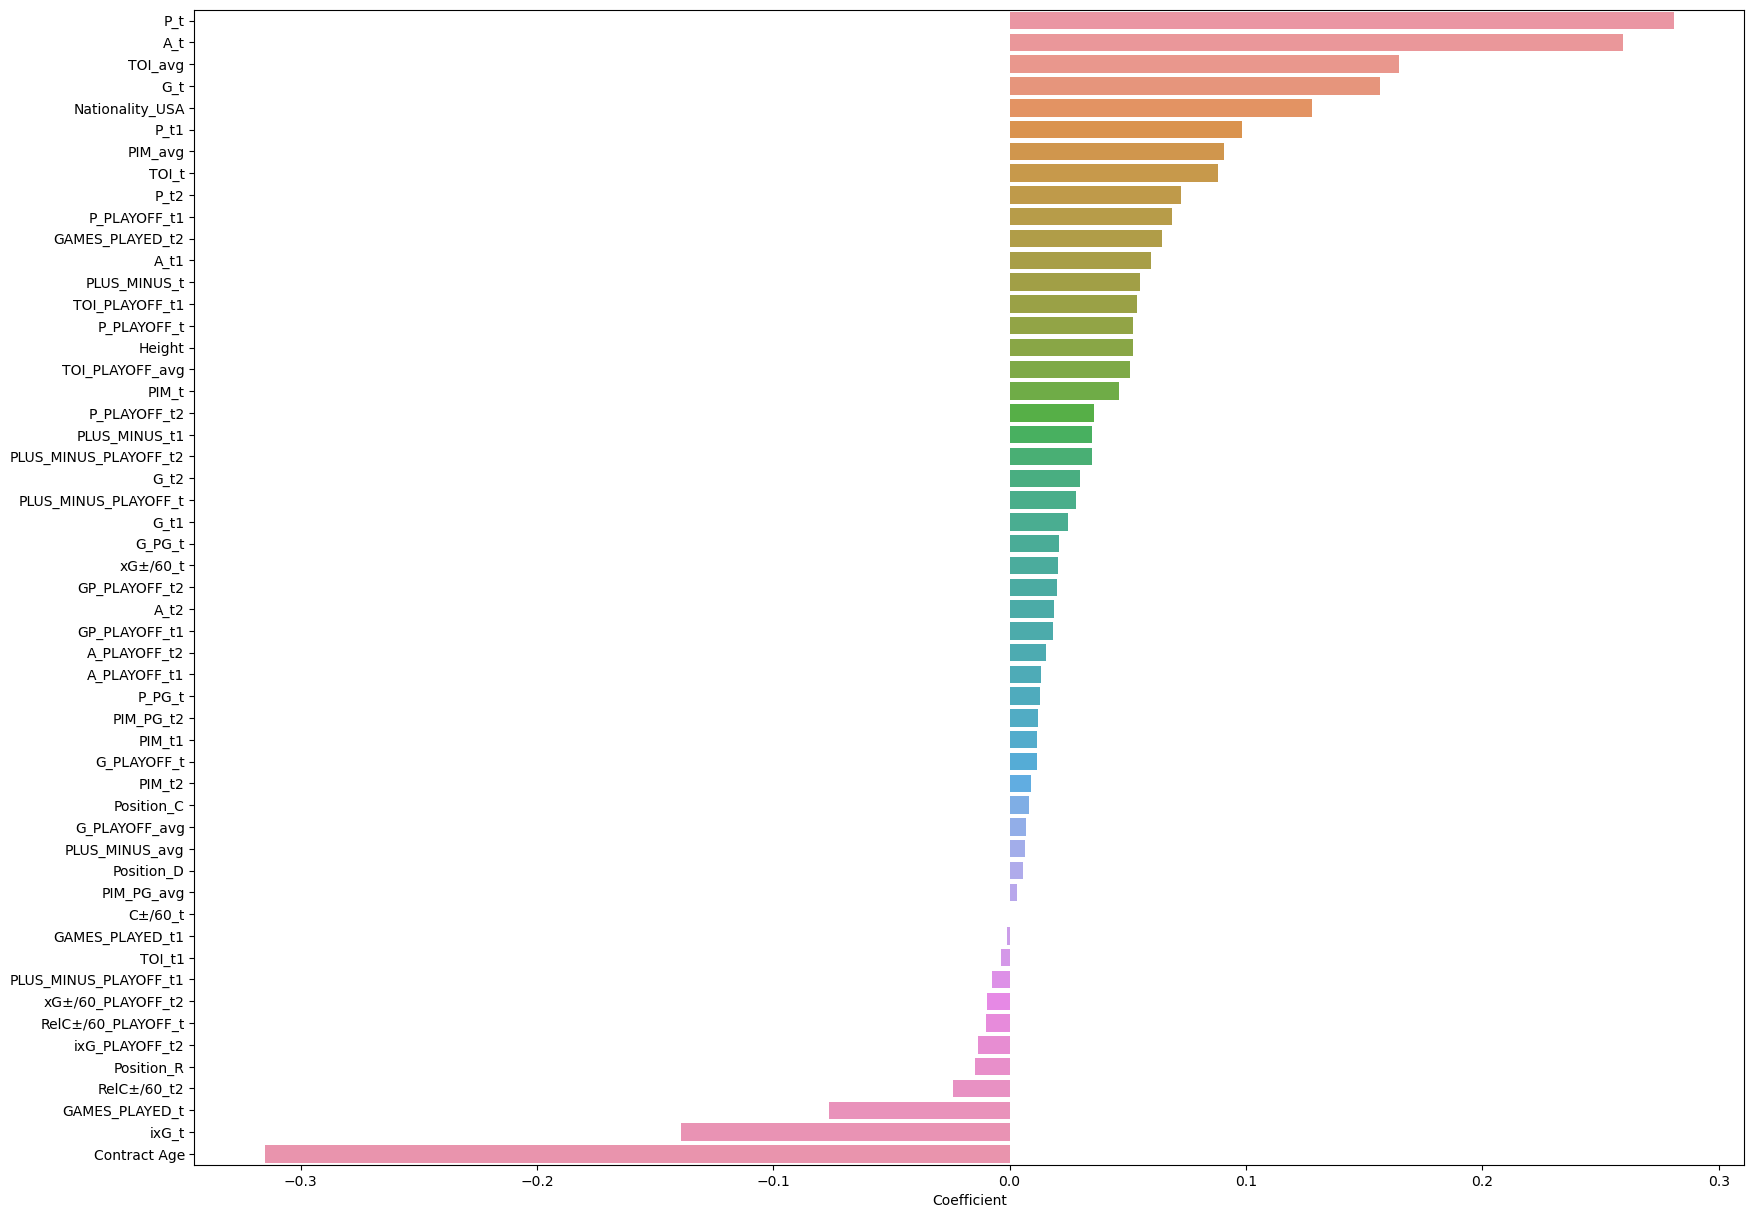

In [313]:
# get coefficients chart
eln_l_coef = pd.DataFrame(pd.Series(eln_l_final.coef_,
                                    index=eln_l_final.feature_names_in_)).sort_values(by=0,ascending=False)
eln_l_coef.columns = ['Coefficient']
eln_l_coef_sub = eln_l_coef[eln_l_coef['Coefficient'] != 0]
fig,ax = plt.subplots(figsize=(20,15))
sns.barplot(y=eln_l_coef_sub.index,x=eln_l_coef_sub['Coefficient']);

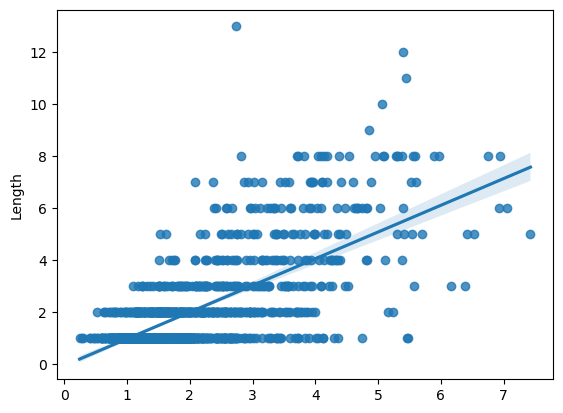

In [314]:
# plot true values vs residuals
sns.regplot(x=eln_l_predict,y=y_l_test);

#### Decision Tree Regression

In [315]:
# initialize Decision Tree Regression
dtr_l = DecisionTreeRegressor(random_state=100)
dtr_parameters_l_1 = {'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
                      'splitter': ['best','random'],
                      'max_depth':[1,5,10,20],
                      'min_samples_split':[1,3,5,7],
                      'max_features':['auto','sqrt','log2']}

In [316]:
# perform grid search
gs_dtr_l_1 = GridSearchCV(dtr_l,dtr_parameters_l_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_dtr_l_1.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100),
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [1, 5, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [1, 3, 5, 7],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_absolute_error', verbose=False)

In [317]:
gs_dtr_l_1.best_score_

-0.7879674918729682

In [318]:
gs_dtr_l_1.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 3,
 'splitter': 'best'}

In [319]:
# enhance grid search
dtr_parameters_l_2 = {'criterion':['absolute_error'],
                    'splitter': ['best'],
                    'max_depth':[2,5,8],
                    'min_samples_split':[1,3,5],
                    'max_features':['auto']}
gs_dtr_l_2 = GridSearchCV(dtr_l,dtr_parameters_l_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_dtr_l_2.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=100),
             param_grid={'criterion': ['absolute_error'],
                         'max_depth': [2, 5, 8], 'max_features': ['auto'],
                         'min_samples_split': [1, 3, 5], 'splitter': ['best']},
             scoring='neg_mean_absolute_error', verbose=False)

In [320]:
gs_dtr_l_2.best_score_

-0.7879674918729682

In [321]:
gs_dtr_l_2.best_params_

{'criterion': 'absolute_error',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 3,
 'splitter': 'best'}

In [324]:
# build final model using best params
dtr_l_final = DecisionTreeRegressor(criterion = 'absolute_error',
                                    splitter = 'best',
                                    max_features = 'auto',
                                    max_depth = 5,
                                    min_samples_split = 3,
                                    random_state = 100)
dtr_l_final.fit(X_train,y_l_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      max_features='auto', min_samples_split=3,
                      random_state=100)

In [325]:
# get final model error
dtr_l_predict = dtr_l_final.predict(X_test)
dtr_l_final_mae = mean_absolute_error(dtr_l_final.predict(X_test),y_l_test)
dtr_l_final_mae

0.7765298218435321

In [326]:
# add eln mae to dataframe
cap_hit_error.loc['Decision Tree Regression','Contract Length'] = dtr_l_final_mae
cap_hit_error

MAE  Contract Length
Ridge Regression          0.008159         0.860498
LASSO Regression          0.009368         0.854807
Elastic Net Regression    0.008190         0.856260
Decision Tree Regression  0.007317         0.776530
Random Forest Regression  0.005912              NaN
XGBoost Regression        0.005765              NaN

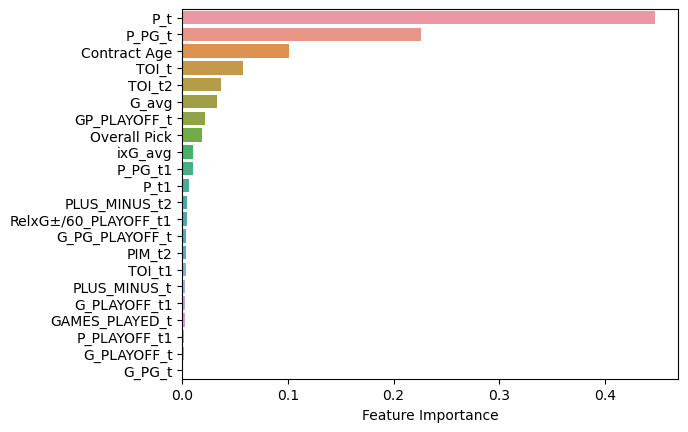

In [327]:
# get feature importance chart
dtr_l_featureImportance = pd.DataFrame(pd.Series(dtr_l_final.feature_importances_,
                                                 index=dtr_l_final.feature_names_in_)).sort_values(by=0,
                                                                                                   ascending=False)
dtr_l_featureImportance.columns = ['Feature Importance']
dtr_l_featureImportance_sub = dtr_l_featureImportance[dtr_l_featureImportance['Feature Importance'] != 0]
sns.barplot(y=dtr_l_featureImportance_sub.index,x=dtr_l_featureImportance_sub['Feature Importance']);

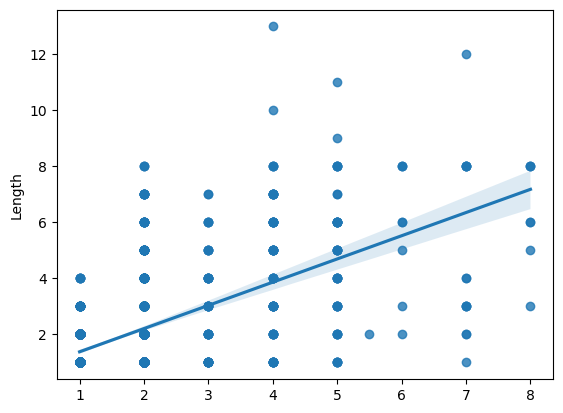

In [330]:
# plot true values vs residuals
sns.regplot(x=dtr_l_predict,y=y_l_test);

#### Random Forest Regression

In [331]:
# initialize Decision Tree Regression
rfr_l = RandomForestRegressor(random_state=100)
rfr_l_parameters_1 = {'n_estimators':[50,100,150]}

In [332]:
# perform grid search
gs_rfr_l_1 = GridSearchCV(rfr_l,rfr_l_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_rfr_l_1.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
             param_grid={'n_estimators': [50, 100, 150]},
             scoring='neg_mean_absolute_error', verbose=False)

In [333]:
gs_rfr_l_1.best_score_

-0.7990551771276151

In [334]:
gs_rfr_l_1.best_params_

{'n_estimators': 150}

In [335]:
# enhance grid search
rfr_l_parameters_2 = {'n_estimators':[150,200,250]}
gs_rfr_l_2 = GridSearchCV(rfr_l,rfr_l_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_rfr_l_2.fit(X_train,y_l_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=100),
             param_grid={'n_estimators': [150, 200, 250]},
             scoring='neg_mean_absolute_error', verbose=False)

In [336]:
gs_rfr_l_2.best_score_

-0.7989960940235058

In [337]:
gs_rfr_l_2.best_params_

{'n_estimators': 200}

In [339]:
# build final model using best params
rfr_l_final = RandomForestRegressor(n_estimators=200,random_state=100)
rfr_l_final.fit(X_train,y_l_train)

RandomForestRegressor(n_estimators=200, random_state=100)

In [340]:
# get final model error
rfr_l_predict = rfr_l_final.predict(X_test)
rfr_l_final_mae = mean_absolute_error(rfr_l_final.predict(X_test),y_l_test)
rfr_l_final_mae

0.7843841982958948

In [341]:
# add rfr mae to dataframe
cap_hit_error.loc['Random Forest Regression','Contract Length'] = rfr_l_final_mae
cap_hit_error

MAE  Contract Length
Ridge Regression          0.008159         0.860498
LASSO Regression          0.009368         0.854807
Elastic Net Regression    0.008190         0.856260
Decision Tree Regression  0.007317         0.776530
Random Forest Regression  0.005912         0.784384
XGBoost Regression        0.005765              NaN

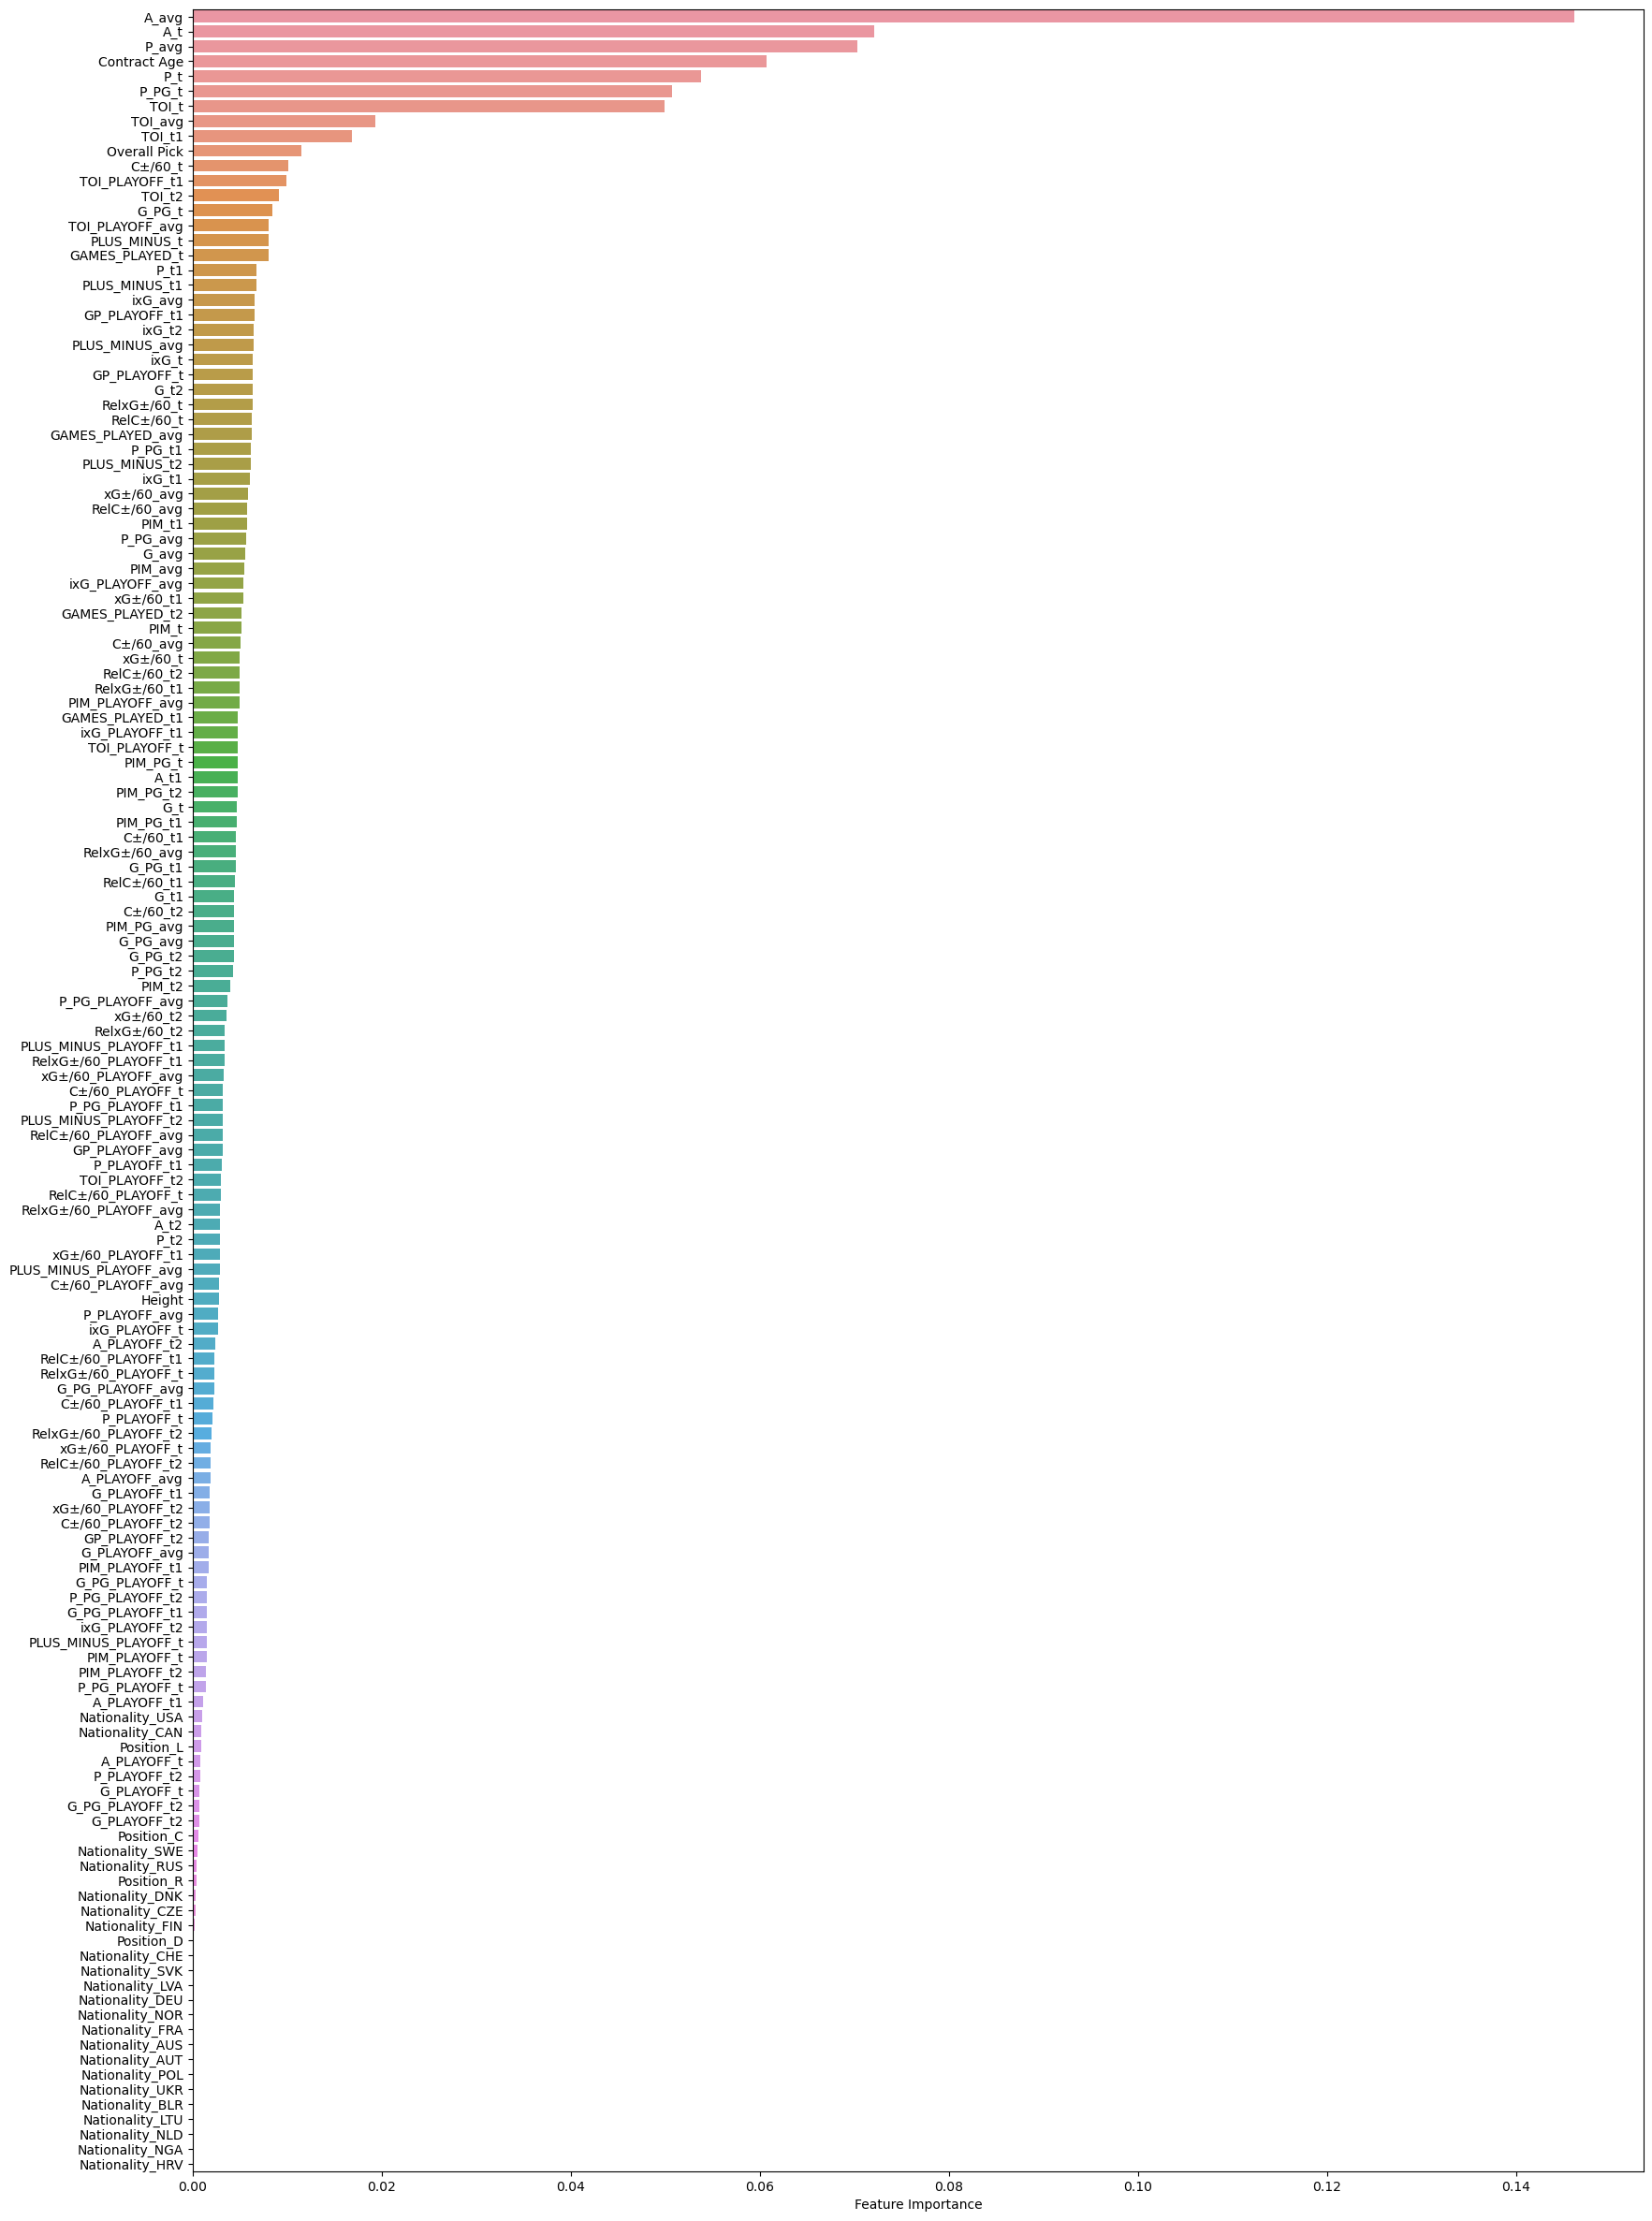

In [343]:
# get feature importance chart
rfr_l_featureImportance = pd.DataFrame(pd.Series(rfr_l_final.feature_importances_,
                                               index=rfr_l_final.feature_names_in_)).sort_values(by=0,ascending=False)
rfr_l_featureImportance.columns = ['Feature Importance']
rfr_l_featureImportance_sub = rfr_l_featureImportance[rfr_l_featureImportance['Feature Importance'] != 0]
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=rfr_l_featureImportance_sub.index,x=rfr_l_featureImportance_sub['Feature Importance']);

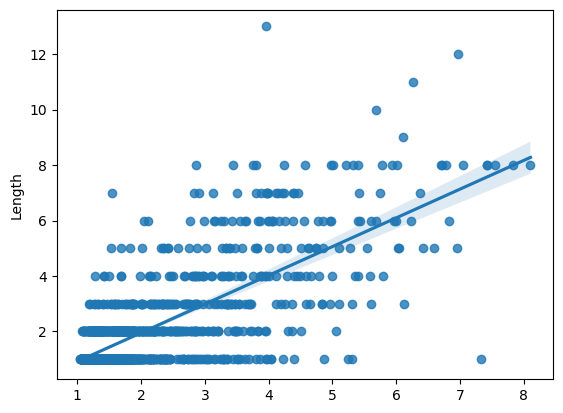

In [344]:
# plot true values vs residuals
sns.regplot(x=rfr_l_predict,y=y_l_test);

#### XGBoost Regression

In [346]:
# initialize XGBoost Regression
xgbr_l = XGBRegressor(random_state=100)
xgbr_l_parameters_1 = {'learning_rate': [0.05,0.10,0.15],
                       'max_depth': [2,5,10],
                       'min_child_weight': [1,3,5],
                       'n_estimators': [20,40,80],
                       'tree_method': ['exact','approx','hist']}

In [347]:
# perform grid search
gs_xgbr_l_1 = GridSearchCV(xgbr_l,xgbr_l_parameters_1,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_l_1.fit(X_train,y_l_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [2, 5, 10], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [20, 40, 80],
                         'tree_method': ['exact', 'approx', 'hist']},
             scoring='neg_mean_absolute_error', verbose=False)

In [348]:
gs_xgbr_l_1.best_score_

-0.7841618941006308

In [349]:
gs_xgbr_l_1.best_params_

{'learning_rate': 0.15,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 80,
 'tree_method': 'exact'}

In [350]:
# enhance grid search
xgbr_l_parameters_2 = {'learning_rate': [0.15],
                     'max_depth': [3,5,8],
                     'min_child_weight': [1,3],
                     'n_estimators': [60,80,95],
                     'tree_method': ['exact']}
gs_xgbr_l_2 = GridSearchCV(xgbr_l,xgbr_l_parameters_2,scoring='neg_mean_absolute_error',cv=5,verbose=False)
gs_xgbr_l_2.fit(X_train,y_l_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=100, ...),
             param_grid={'learning_rate': [0.15], 'max_depth': [3, 5, 8],
                         'min_child_weight': [1, 3],
                         'n_estimators': [60, 80, 95],
                         'tree_method': ['exact']},
             scoring='neg_mean_absolute_error', verbose=False)

In [351]:
gs_xgbr_l_2.best_score_

-0.7841618941006308

In [352]:
gs_xgbr_l_2.best_params_

{'learning_rate': 0.15,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 80,
 'tree_method': 'exact'}

In [353]:
# build final model using best params
xgbr_l_final = XGBRegressor(learning_rate=0.15,
                            max_depth=5,
                            min_child_weight=3,
                            n_estimators=80,
                            tree_method='exact',
                            random_state=100)
xgbr_l_final.fit(X_train,y_l_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=100, ...)

In [354]:
# get final model error
xgbr_l_predict = xgbr_l_final.predict(X_test)
xgbr_l_final_mae = mean_absolute_error(xgbr_l_final.predict(X_test),y_l_test)
xgbr_l_final_mae

0.7799974296423791

In [355]:
# add xgbr mae to dataframe
cap_hit_error.loc['XGBoost Regression','Contract Length'] = xgbr_l_final_mae
cap_hit_error

MAE  Contract Length
Ridge Regression          0.008159         0.860498
LASSO Regression          0.009368         0.854807
Elastic Net Regression    0.008190         0.856260
Decision Tree Regression  0.007317         0.776530
Random Forest Regression  0.005912         0.784384
XGBoost Regression        0.005765         0.779997

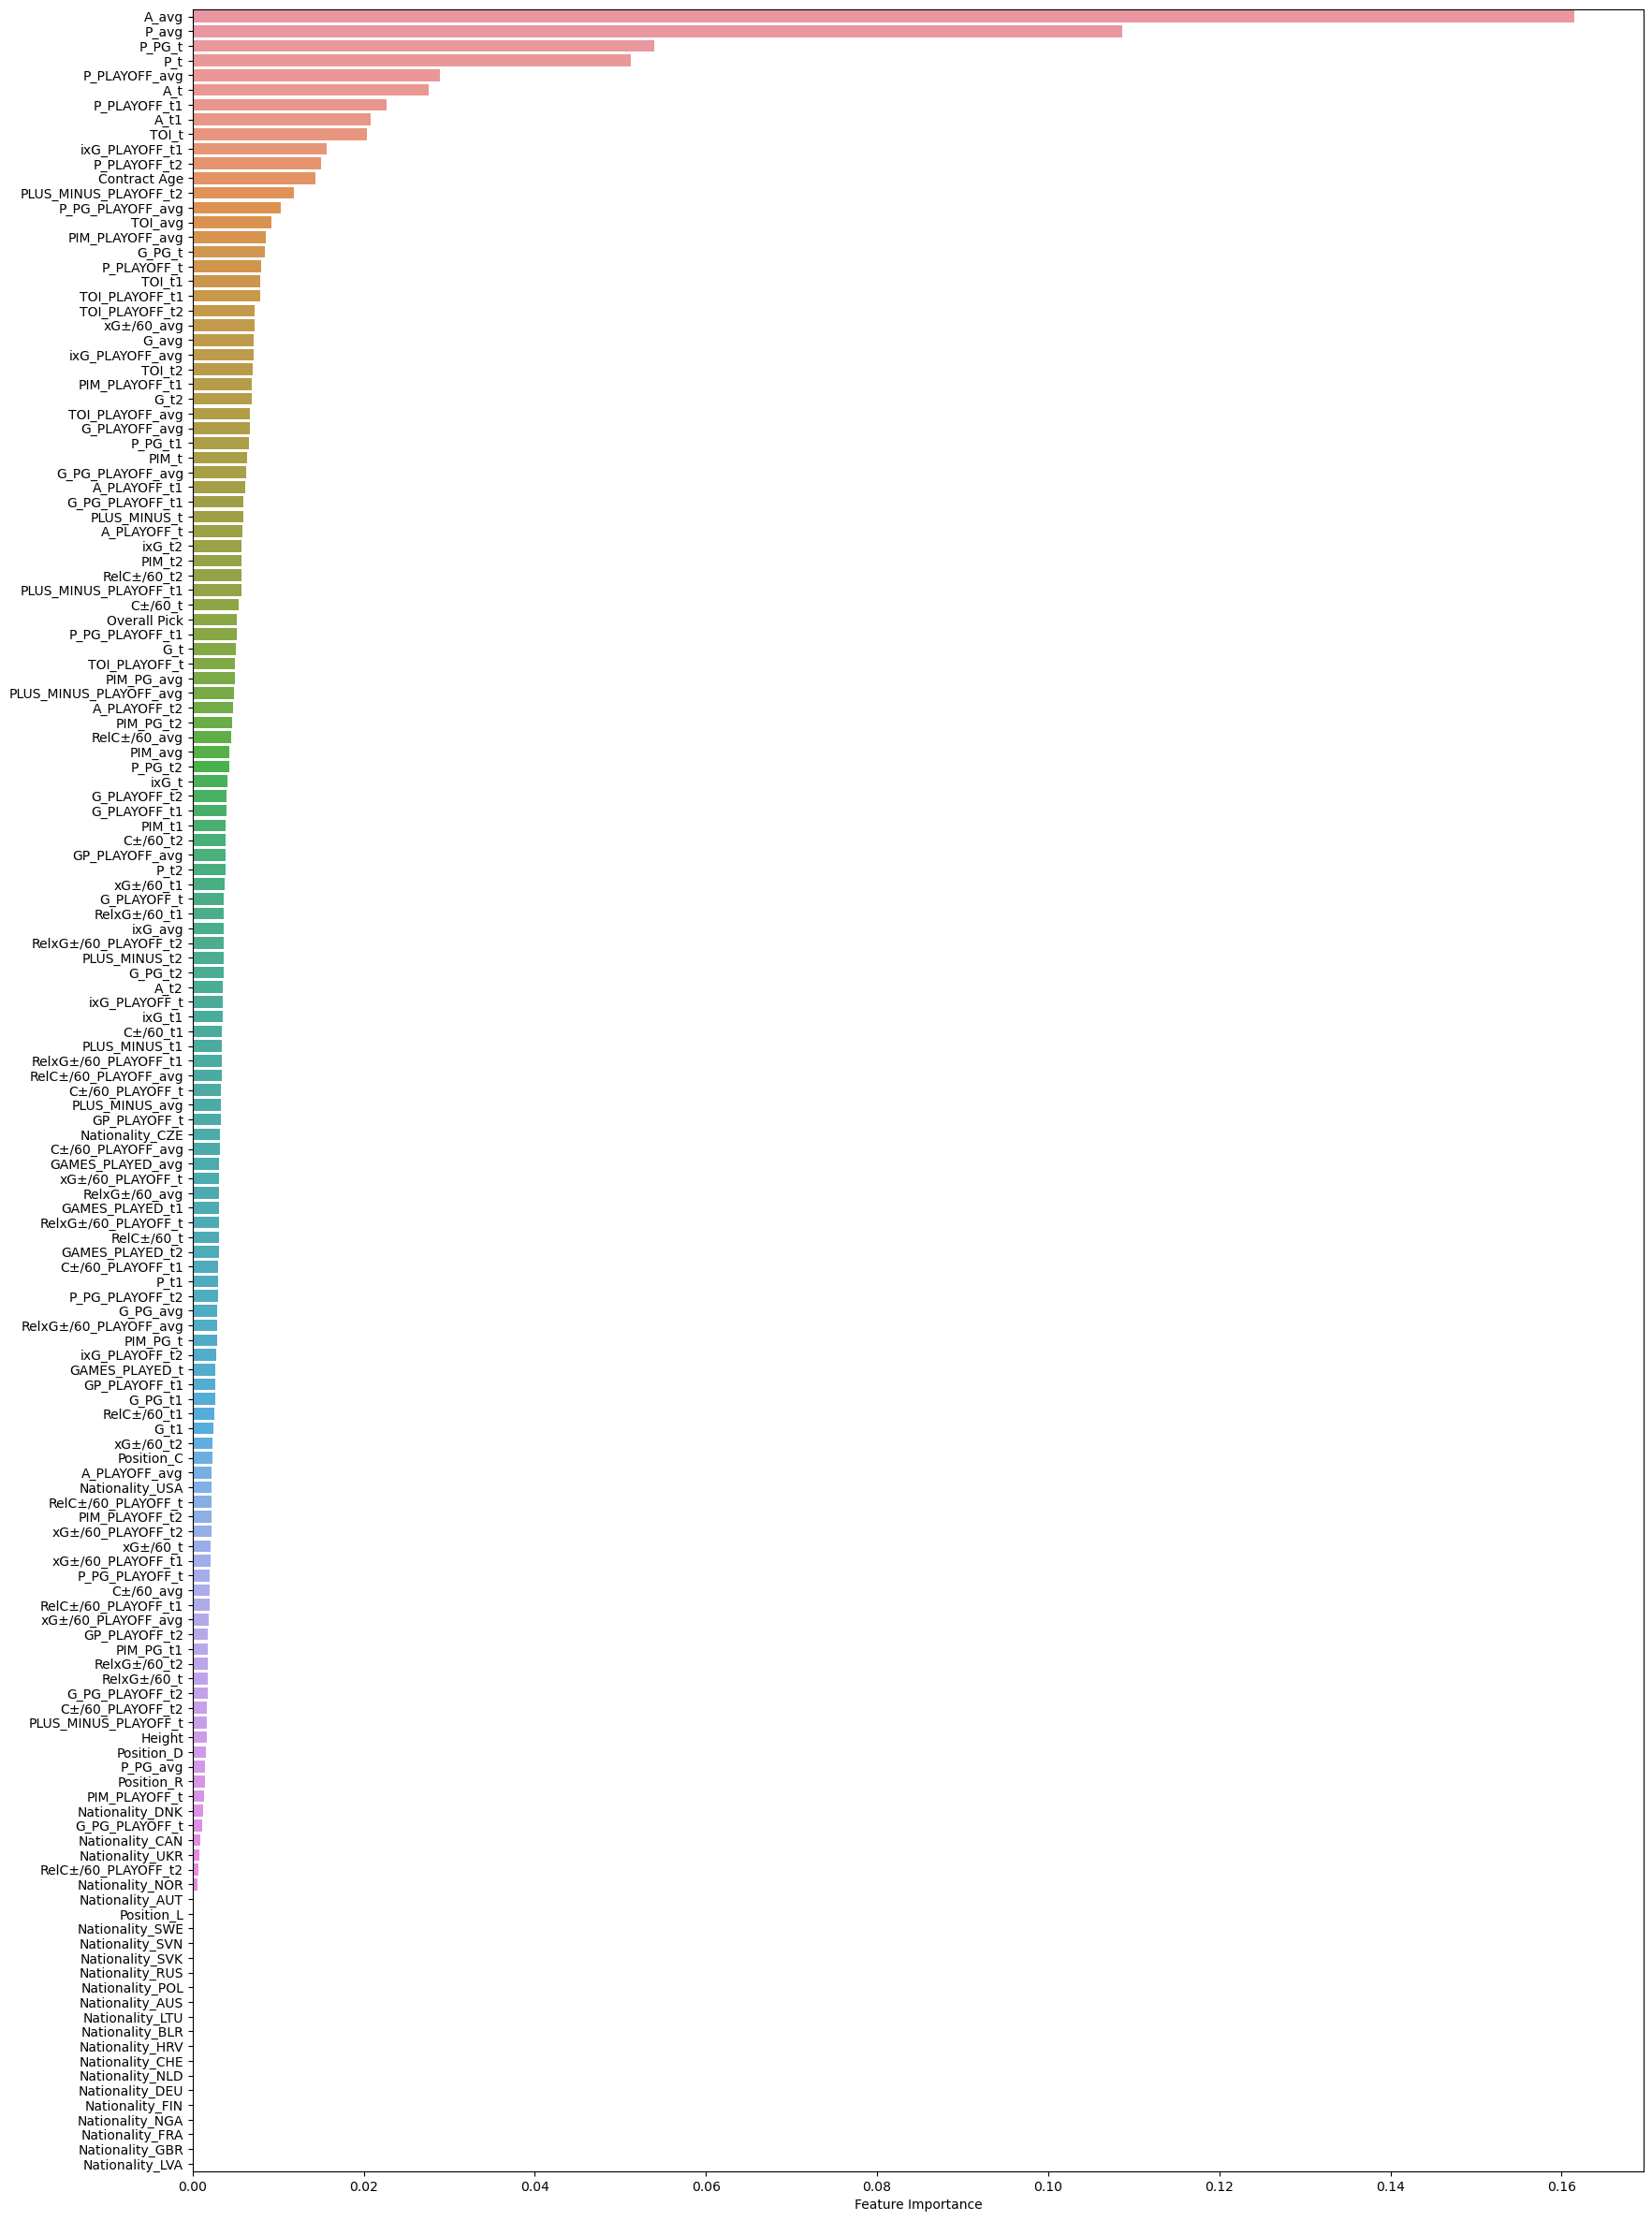

In [356]:
# get feature importance chart
xgbr_l_featureImportance = pd.DataFrame(pd.Series(xgbr_l_final.feature_importances_,
                                                  index=xgbr_l_final.feature_names_in_)).sort_values(by=0,
                                                                                                     ascending=False)
xgbr_l_featureImportance.columns = ['Feature Importance']
fig,ax = plt.subplots(figsize=(20,30))
sns.barplot(y=xgbr_l_featureImportance.index,x=xgbr_l_featureImportance['Feature Importance']);

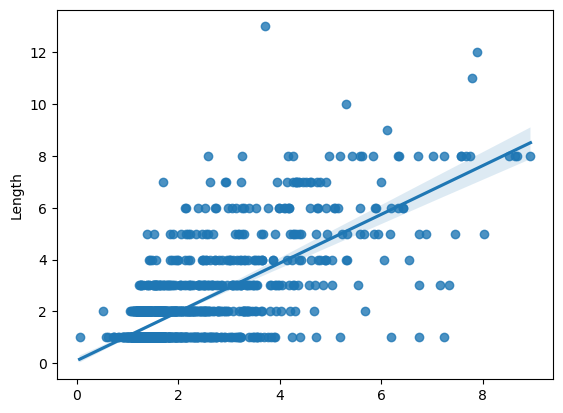

In [357]:
# plot true values vs residuals
sns.regplot(x=xgbr_l_predict,y=y_l_test);

## Evaluation

Now that we have run all of the models, we can select the ones that we should use to project the different components of the model. We start by reviewing the table of all the model outputs.

In [2]:
cap_hit_error

NameError: name 'cap_hit_error' is not defined

The table, which shows the output of all the models, suggests that based on MAE, the chosen error metric, the models used should be XGBoost regression for predicting annual contract value, and decision tree regression for predicting contract length. 

## Deployment

To actually make use of the model, we must first load in the test data and apply the same pre-processing as we did to the original data.

In [94]:
# load in new data
data_new = pd.read_csv('new_contract_players.csv')

In [95]:
data_new.head()

Name  ContractAge Position Nationality  Height  Overall Pick  \
0     Zach Parise         39.0        L         USA    71.0          17.0   
1  Damon Severson         29.0        D         CAN    74.0          60.0   
2      John Moore         33.0        D         USA    75.0          21.0   
3      Miles Wood         28.0        L         USA    74.0         100.0   
4  Steven Santini         28.0        D         USA    74.0          42.0   

   GAMES_PLAYED_t   G_t   A_t   P_t  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0            82.0  21.0  13.0  34.0  ...         0.563333           -0.200000   
1            81.0   7.0  26.0  33.0  ...         0.110000            0.073333   
2             0.0   0.0   0.0   0.0  ...         0.000000            0.000000   
3            76.0  13.0  14.0  27.0  ...         0.310000           -0.043333   
4             4.0   0.0   1.0   1.0  ...         0.050000            0.630000   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0               0.073333         -14.293333             -6.610000  0.198193   
1              -0.016667           1.773333              1.770000  0.092497   
2               0.000000           0.000000              0.000000  0.000000   
3              -0.086667          -6.646667             -5.193333  0.160048   
4               1.353333          29.753333             37.203333  0.000000   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0  0.413821    0.255827          0.166667          0.250000  
1  0.452469    0.566498          0.027778          0.083333  
2  0.271429    0.485714          0.000000          0.000000  
3  0.269936    0.953535          0.083333          0.083333  
4  0.194444    0.166667          0.000000          0.000000  

[5 rows x 122 columns]

In [96]:
data_new.shape

(184, 122)

Since we are going to train the models on the full training data set, we can re-apply the preprocessing steps to the training data, and then repeat for the test data. This ensures that there is no additional randomness being introduced into the model.

In [97]:
# training data review
data.head()

Contract Age Position Nationality  Height  Overall Pick  GAMES_PLAYED_t  \
0          34.0        L         USA    73.0          32.0            54.0   
1          37.0        L         USA    73.0          32.0             0.0   
2          38.0        L         USA    73.0          32.0            62.0   
3          36.0        L         USA    73.0          32.0            52.0   
6          36.0        R         USA    73.0          35.0            31.0   

    G_t   A_t   P_t  PLUS_MINUS_t  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0  12.0  12.0  24.0          10.0  ...         0.203333           -0.143333   
1   0.0   0.0   0.0           0.0  ...         0.310000           -0.080000   
2   1.0   2.0   3.0         -14.0  ...         0.000000            0.000000   
3   4.0   5.0   9.0         -10.0  ...         0.410000           -0.196667   
6   4.0  10.0  14.0         -15.0  ...         0.470000            0.063333   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0              -0.093333          -3.380000             -1.830000  0.167570   
1              -0.055000          -3.365000              0.485000  0.079445   
2               0.000000           0.000000              0.000000  0.046526   
3              -0.130000          -5.623333             -1.506667  0.127038   
6               0.100000           9.790000              6.630000  0.240542   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0  0.339205    0.233363          0.067340          0.215488  
1  0.168506    0.139660          0.071429          0.071429  
2  0.110732    0.122208          0.000000          0.000000  
3  0.260485    0.228909          0.047619          0.047619  
6  0.685517    0.583566          0.166667          0.316667  

[5 rows x 121 columns]

In [98]:
data = data.drop(columns=['Length','Cap Hit'],axis=1)

KeyError: "['Length', 'Cap Hit'] not found in axis"

In [99]:
# split data into categorical variables
categorical_variables = ['Position','Nationality']
data_categorical = data[categorical_variables]
data_numeric = data.drop(columns=categorical_variables,axis=1)

# encode categorical variables
ohe_data = OneHotEncoder(sparse=False)
data_categorical = ohe_data.fit_transform(data_categorical)
data_categorical = pd.DataFrame(data_categorical,columns=ohe_data.get_feature_names_out())

# scale numeric variables
scaler_data = StandardScaler()
data_numeric = scaler_data.fit_transform(data_numeric)
data_numeric = pd.DataFrame(data_numeric,columns=scaler_data.get_feature_names_out())

# re-combine categorical and numeric features
data_train = pd.concat([data_categorical,data_numeric],axis=1)

In [100]:
data_train.shape

(5163, 147)

Now that we have scaled the training data to fit the model in entirety, we can apply the same scaling and processing to the full new data.

In [101]:
# save player names for the final set
player_names = data_new['Name']
data_new = data_new.drop(columns=['Name'],axis=1)
data_new = data_new.rename(columns = {'ContractAge':'Contract Age'})

In [102]:
data_new.head()

Contract Age Position Nationality  Height  Overall Pick  GAMES_PLAYED_t  \
0          39.0        L         USA    71.0          17.0            82.0   
1          29.0        D         CAN    74.0          60.0            81.0   
2          33.0        D         USA    75.0          21.0             0.0   
3          28.0        L         USA    74.0         100.0            76.0   
4          28.0        D         USA    74.0          42.0             4.0   

    G_t   A_t   P_t  PLUS_MINUS_t  ...  ixG_PLAYOFF_avg  xG±/60_PLAYOFF_avg  \
0  21.0  13.0  34.0           7.0  ...         0.563333           -0.200000   
1   7.0  26.0  33.0           9.0  ...         0.110000            0.073333   
2   0.0   0.0   0.0           0.0  ...         0.000000            0.000000   
3  13.0  14.0  27.0           1.0  ...         0.310000           -0.043333   
4   0.0   1.0   1.0           0.0  ...         0.050000            0.630000   

   RelxG±/60_PLAYOFF_avg  C±/60_PLAYOFF_avg  RelC±/60_PLAYOFF_avg  G_PG_avg  \
0               0.073333         -14.293333             -6.610000  0.198193   
1              -0.016667           1.773333              1.770000  0.092497   
2               0.000000           0.000000              0.000000  0.000000   
3              -0.086667          -6.646667             -5.193333  0.160048   
4               1.353333          29.753333             37.203333  0.000000   

   P_PG_avg  PIM_PG_avg  G_PG_PLAYOFF_avg  P_PG_PLAYOFF_avg  
0  0.413821    0.255827          0.166667          0.250000  
1  0.452469    0.566498          0.027778          0.083333  
2  0.271429    0.485714          0.000000          0.000000  
3  0.269936    0.953535          0.083333          0.083333  
4  0.194444    0.166667          0.000000          0.000000  

[5 rows x 121 columns]

In [105]:
# split data
data_new_categorical = data_new[categorical_variables]
data_new_numeric = data_new.drop(columns=categorical_variables,axis=1)

# encode categorical variables
data_new_categorical = ohe_data.transform(data_new_categorical)
data_new_categorical = pd.DataFrame(data_new_categorical,columns=ohe_data.get_feature_names_out())

# scale numeric variables
data_new_numeric = scaler_data.transform(data_new_numeric)
data_new_numeric = pd.DataFrame(data_new_numeric,columns=scaler_data.get_feature_names_out())

# re-combine categorical and numeric features
data_new = pd.concat([data_new_categorical,data_new_numeric],axis=1)

In [107]:
data_new.shape

(184, 147)

Now that the new data is processed and able to be inputted into the model, we can train the final models that we have chosen and obtain the output.

In [108]:
# train XGBoost regression model for predicting contract value
xgbr_final = XGBRegressor(learning_rate=0.1,
                          max_depth=8,
                          min_child_weight=10,
                          n_estimators=115,
                          tree_method='approx',
                          random_state=100)
xgbr_final.fit(data_train,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             n_estimators=115, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=100, ...)

In [110]:
# get predicted values
contract_values = xgbr_final.predict(data_new)

In [111]:
# train decision tree regression model for predicting contract value
dtr_l_final = DecisionTreeRegressor(criterion = 'absolute_error',
                                    splitter = 'best',
                                    max_features = 'auto',
                                    max_depth = 5,
                                    min_samples_split = 3,
                                    random_state = 100)
dtr_l_final.fit(data_train,y_l)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      max_features='auto', min_samples_split=3,
                      random_state=100)

In [112]:
contract_lengths = dtr_l_final.predict(data_new)

In [113]:
# create new dataframe with results
results = pd.DataFrame({'Name': player_names,
                        'Contract Annual Value': contract_values,
                        'Contract Length': contract_lengths})

In [115]:
results.head()

Name  Contract Annual Value  Contract Length
0     Zach Parise               0.022923              1.0
1  Damon Severson               0.069559              3.0
2      John Moore               0.008365              1.0
3      Miles Wood               0.020088              2.0
4  Steven Santini               0.009906              1.0

Since we know that the total salary cap for the upcoming season is 83.5 million, we can apply that to the results to get the annual contract value in millions, as well as the predicted total contract value.

In [120]:
results['Contract Annual Value (mio)'] = results['Contract Annual Value']*83.5
results['Total Contract Value'] = results['Contract Annual Value (mio)']*results['Contract Length']
results = results.set_index('Name')

KeyError: "None of ['Name'] are in the columns"

In [127]:
pd.set_option('display.max_rows', None)

In [128]:
results

Contract Annual Value  Contract Length  \
Name                                                               
Zach Parise                            0.022923              1.0   
Damon Severson                         0.069559              3.0   
John Moore                             0.008365              1.0   
Miles Wood                             0.020088              2.0   
Steven Santini                         0.009906              1.0   
Will Butcher                           0.010240              1.0   
Connor Carrick                         0.011489              1.0   
Wayne Simmonds                         0.010630              1.0   
John Hayden                            0.009829              1.0   
Dakota Mermis                          0.008354              1.0   
Dmitry Kulikov                         0.029735              2.0   
Ryan Murray                            0.009852              1.0   
Andreas Johnsson                       0.013766              1.0   
Tomas Tatar                            0.051507              2.0   
Mason Geertsen                         0.009163              1.0   
Ryan Graves                            0.056452              5.0   
Travis Hamonic                         0.019739              2.0   
Scott Mayfield                         0.068099              5.0   
Chris Wagner                           0.009241              1.0   
Derick Brassard                        0.014515              1.0   
Cole Bardreau                          0.008541              1.0   
Richard Panik                          0.008345              1.0   
Marc Staal                             0.019892              1.0   
Derek Stepan                           0.011111              2.0   
Anton Stralman                         0.014417              1.0   
Carl Hagelin                           0.010461              1.0   
Dylan McIlrath                         0.008845              1.0   
Jesper Fast                            0.035778              2.0   
Eric Staal                             0.016764              1.0   
Jayson Megna                           0.008499              1.0   
Steven Kampfer                         0.008939              1.0   
Nick Holden                            0.016667              1.0   
Kevin Shattenkirk                      0.036432              2.0   
Vladislav Namestnikov                  0.016733              2.0   
Vinni Lettieri                         0.008786              1.0   
Brendan Lemieux                        0.018494              1.0   
Jack Johnson                           0.026784              1.0   
Anthony Bitetto                        0.009114              1.0   
Ryan Reaves                            0.012245              1.0   
Tyler Motte                            0.010018              1.0   
Dryden Hunt                            0.011736              1.0   
Luke Schenn                            0.029425              2.0   
Shayne Gostisbehere                    0.071524              3.0   
Pierre-Edouard Bellemare               0.007307              1.0   
Sam Gagner                             0.008503              2.0   
Radko Gudas                            0.034610              2.0   
Robert Hagg                            0.012283              1.0   
Justin Bailey                          0.008958              1.0   
Derek Grant                            0.014213              2.0   
Tyler Pitlick                          0.010971              2.0   
Patrick Brown                          0.010082              1.0   
Max Willman                            0.008823              1.0   
Jordan Staal                           0.040645              1.0   
Brian Dumoulin                         0.057882              5.0   
Patric Hornqvist                       0.013166              1.0   
Ian Cole                               0.043066              2.0   
Scott Harrington                       0.010704              1.0   
Nick Bonino   